## Advanced Lane Finding Project

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [45]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from utility import util

#### Train camera caliberation

In [46]:
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
#        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#        plt.imshow(img)
#        plt.show()

In [47]:
img = cv2.imread('./images/project/37.jpg')
#img = cv2.imread('./images/challenge/9.jpg')
#img = cv2.imread('./images/harder/97.jpg')

In [48]:
img = util.gaussian_blur(img, 15)

### Apply a distortion correction to raw images.

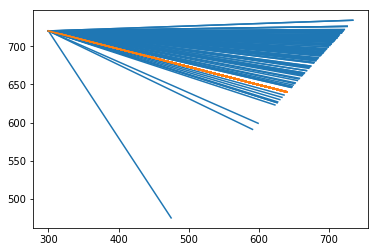

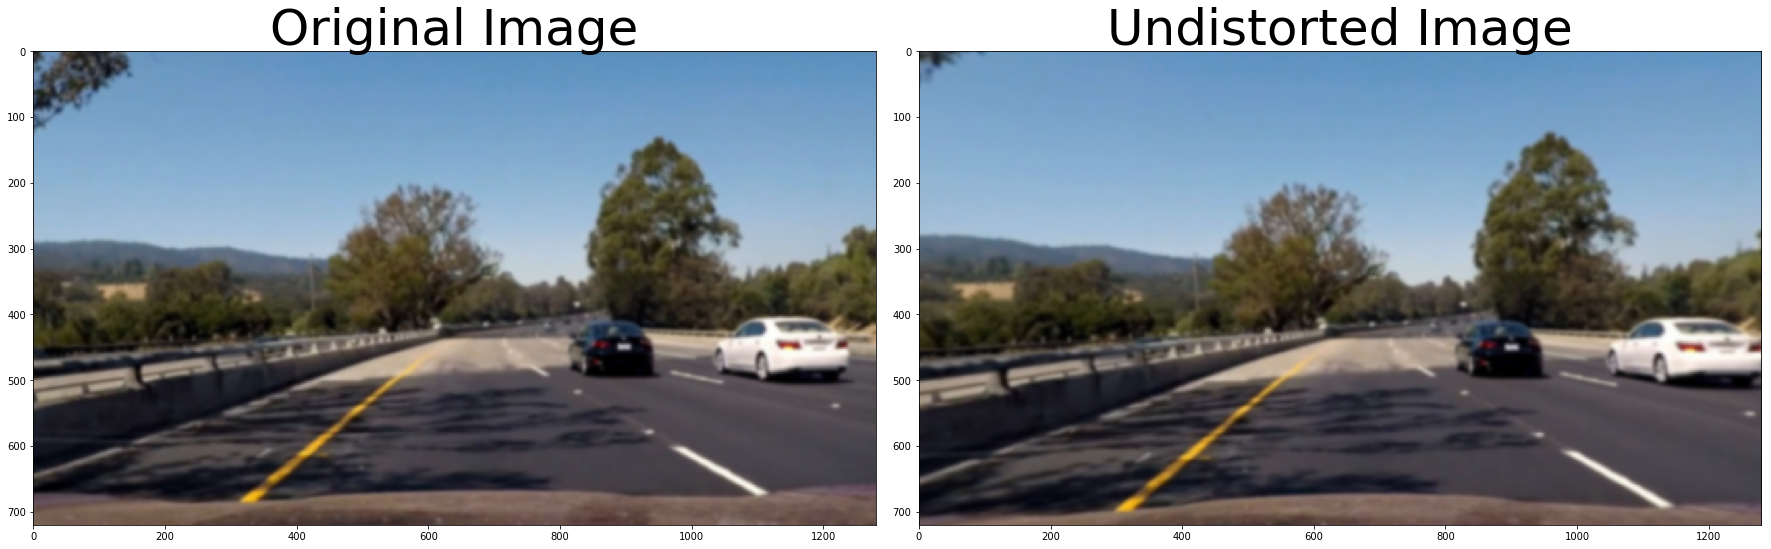

In [49]:
undistorted = util.cal_undistort(img, objpoints, imgpoints)

util.pltPairedShow(img, 'Original Image', undistorted, 'Undistorted Image')

### Use color transforms, gradients, etc., to create a thresholded binary image.

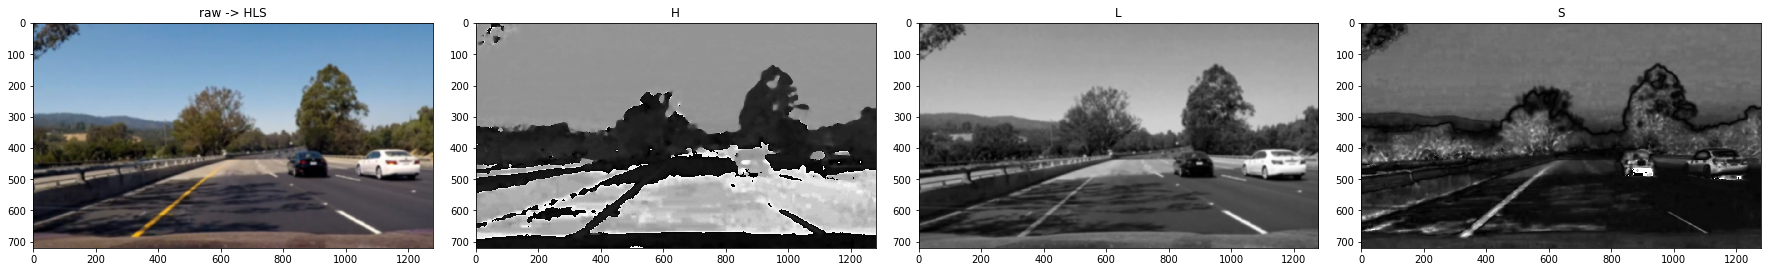

In [50]:
#inspect HLS colorspace
imgHLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

util.pltShowFour(img, 'raw -> HLS', imgHLS[:,:,0], 'H', imgHLS[:,:,1], 'L', imgHLS[:,:,2], 'S')

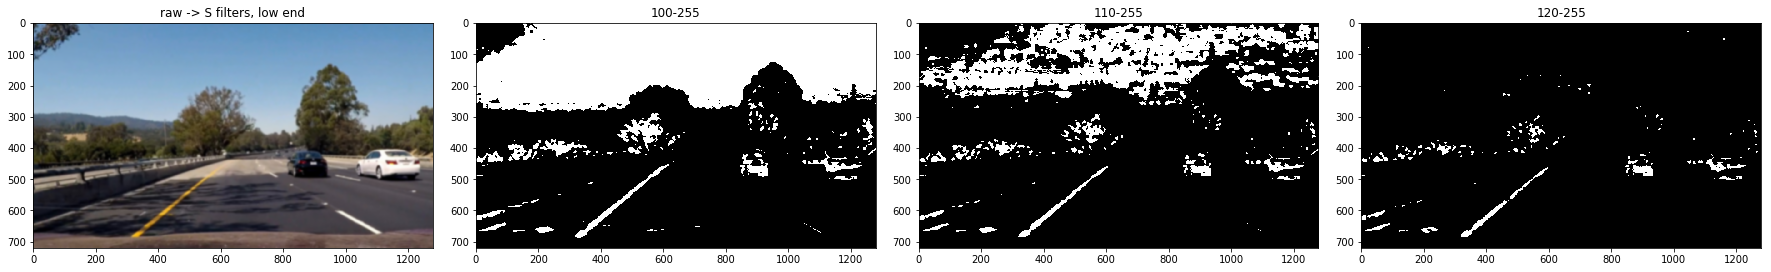

In [51]:
#impact of different threshold settings - low threshold
s_filtered_1 = util.hls_s_thresh(img, Sthresh=(100, 255))
s_filtered_2 = util.hls_s_thresh(img, Sthresh=(110, 255))
s_filtered_3 = util.hls_s_thresh(img, Sthresh=(120, 255))
util.pltShowFour(img, 'raw -> S filters, low end', s_filtered_1, '100-255', s_filtered_2, '110-255', s_filtered_3, '120-255')

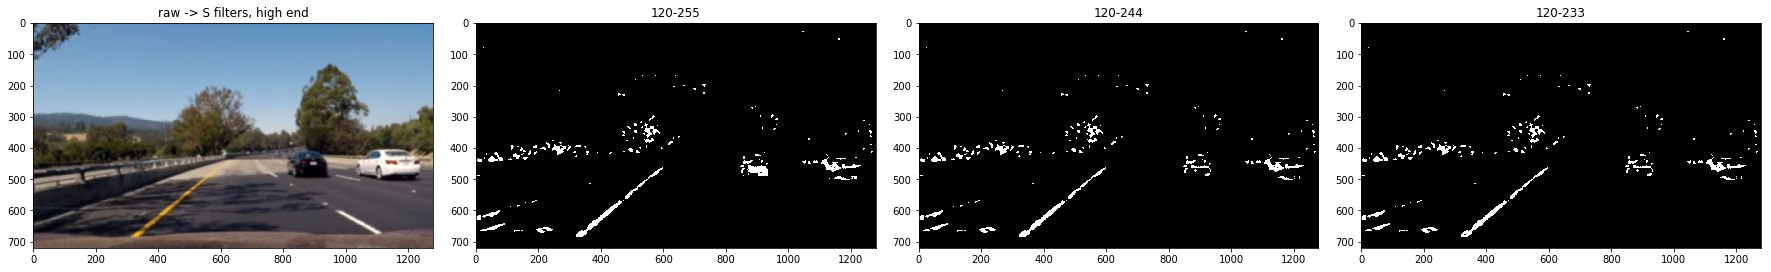

In [52]:
#inpact of different threshold settings - high threshold
s_filtered_1 = util.hls_s_thresh(img, Sthresh=(120, 255))
s_filtered_2 = util.hls_s_thresh(img, Sthresh=(120, 244))
s_filtered_3 = util.hls_s_thresh(img, Sthresh=(120, 233))
util.pltShowFour(img, 'raw -> S filters, high end', s_filtered_1, '120-255', s_filtered_2, '120-244', s_filtered_3, '120-233')

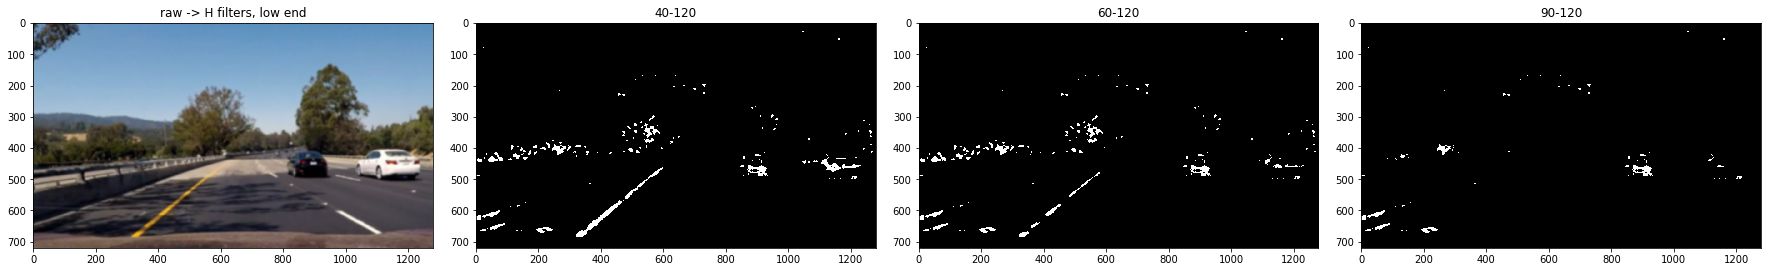

In [53]:
#impact of the color space filtering
s_filtered_1 = util.hls_s_thresh(img, Hthresh=(10, 120), Sthresh=(120, 255))
s_filtered_2 = util.hls_s_thresh(img, Hthresh=(20, 120), Sthresh=(120, 255))
s_filtered_3 = util.hls_s_thresh(img, Hthresh=(30, 120), Sthresh=(120, 255))
util.pltShowFour(img, 'raw -> H filters, low end', s_filtered_1, '40-120', s_filtered_2, '60-120', s_filtered_3, '90-120')

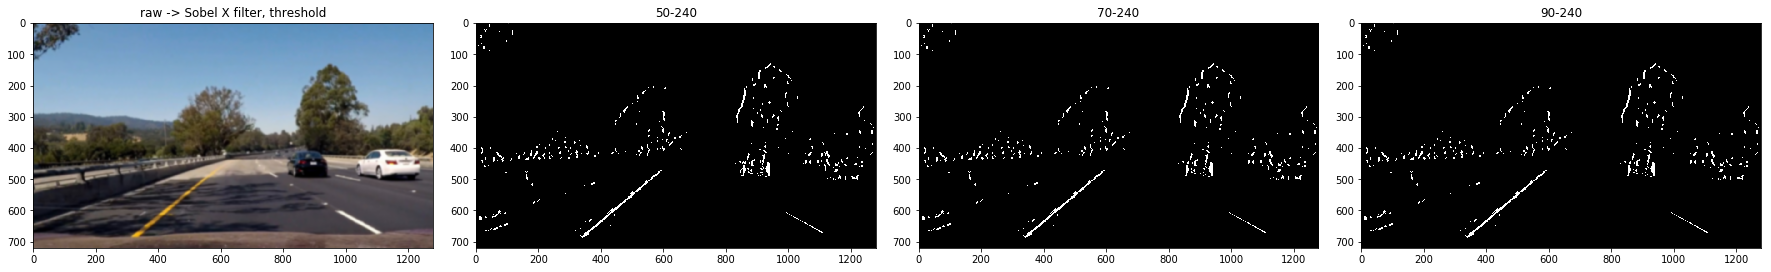

In [54]:
#Sobel X filtered
s_filtered_1 = util.sobelX_thresh(img, 5,(50,240))
s_filtered_2 = util.sobelX_thresh(img, 5,(70,240))
s_filtered_3 = util.sobelX_thresh(img, 5,(90,240))
util.pltShowFour(img, 'raw -> Sobel X filter, threshold', s_filtered_1, '50-240', s_filtered_2, '70-240', s_filtered_3, '90-240')

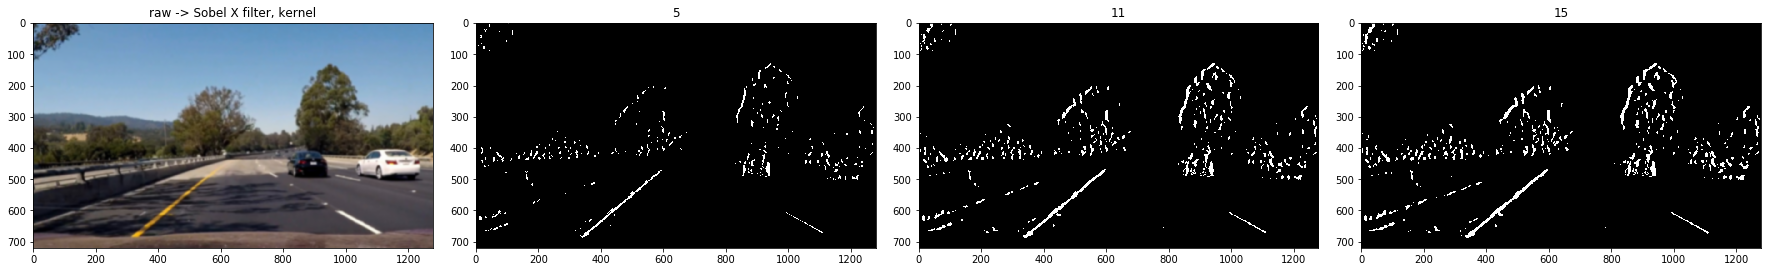

In [55]:
#Sobel X filtered
s_filtered_1 = util.sobelX_thresh(img, 5,(70,240))
s_filtered_2 = util.sobelX_thresh(img, 11,(70,240))
s_filtered_3 = util.sobelX_thresh(img, 15,(70,240))
util.pltShowFour(img, 'raw -> Sobel X filter, kernel', s_filtered_1, '5', s_filtered_2, '11', s_filtered_3, '15')

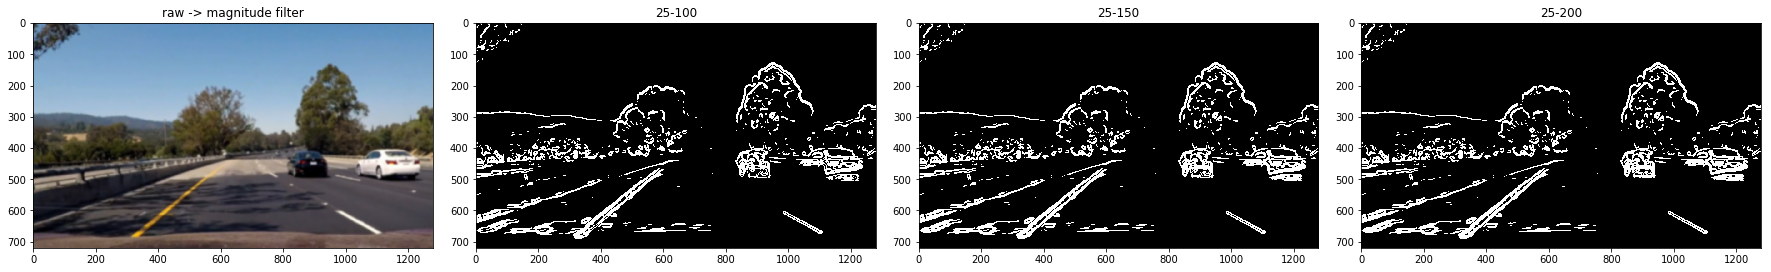

In [56]:
#magnitude filtered
s_filtered_1 = util.mag_thresh(img, 15,(25,100))
s_filtered_2 = util.mag_thresh(img, 15,(25,150))
s_filtered_3 = util.mag_thresh(img, 15,(25,200))
util.pltShowFour(img, 'raw -> magnitude filter', s_filtered_1, '25-100', s_filtered_2, '25-150', s_filtered_3, '25-200')

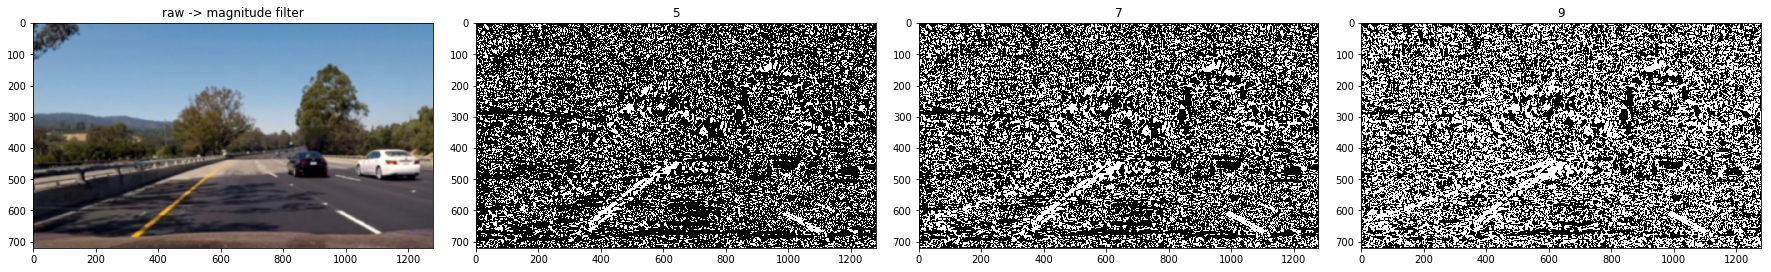

In [57]:
#direction filtered
s_filtered_1 = util.dir_threshold(img, 15,(0.7, 1.2))
s_filtered_2 = util.dir_threshold(img, 15,(0.7, 1.3))
s_filtered_3 = util.dir_threshold(img, 15,(0.7, 1.4))
util.pltShowFour(img, 'raw -> magnitude filter', s_filtered_1, '5', s_filtered_2, '7', s_filtered_3, '9')

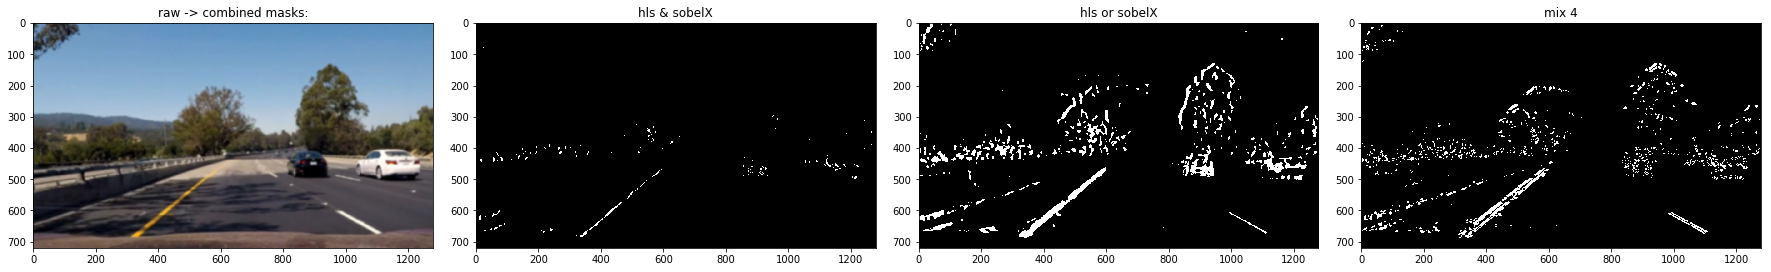

In [58]:
#filter fusion
combined1 = np.zeros_like(img[:,:,2])
combined2 = np.zeros_like(img[:,:,2])
combined3 = np.zeros_like(img[:,:,2])

hls_mask = util.hls_s_thresh(img, Hthresh=(10, 120), Sthresh=(120, 255))[:,:,2]
sobelX_mask = util.sobelX_thresh(img, 15,(70,240))
mag_mask = util.mag_thresh(img, 15,(25,100))
dir_mask = util.dir_threshold(img, 15,(0.7, 1.2))

combined1[(hls_mask >=100 ) & (sobelX_mask >=100)] = 255
combined2[(hls_mask >=100 ) | (sobelX_mask >=100)] = 255
combined3[(((hls_mask >=100 ) & (sobelX_mask >=100)) | ((mag_mask >= 100) & (dir_mask >= 100)))] = 255

util.pltShowFour(img, 'raw -> combined masks:', combined1, 'hls & sobelX', combined2, 'hls or sobelX', combined3, 'mix 4')

### Apply a perspective transform to rectify binary image ("birds-eye view").

In [59]:
src = np.float32([[565, 470],[720, 470],[290,680],[1090,680]])
dst = np.float32([[290, 100],[1090, 100],[290,680],[1090,680]])
Minv = cv2.getPerspectiveTransform(dst, src)

In [60]:
src = np.float32([[565, 470],[720, 470],[290,680],[1090,680]])
dst = np.float32([[290, 100],[1090, 100],[290,680],[1090,680]])
Minv = cv2.getPerspectiveTransform(dst, src)

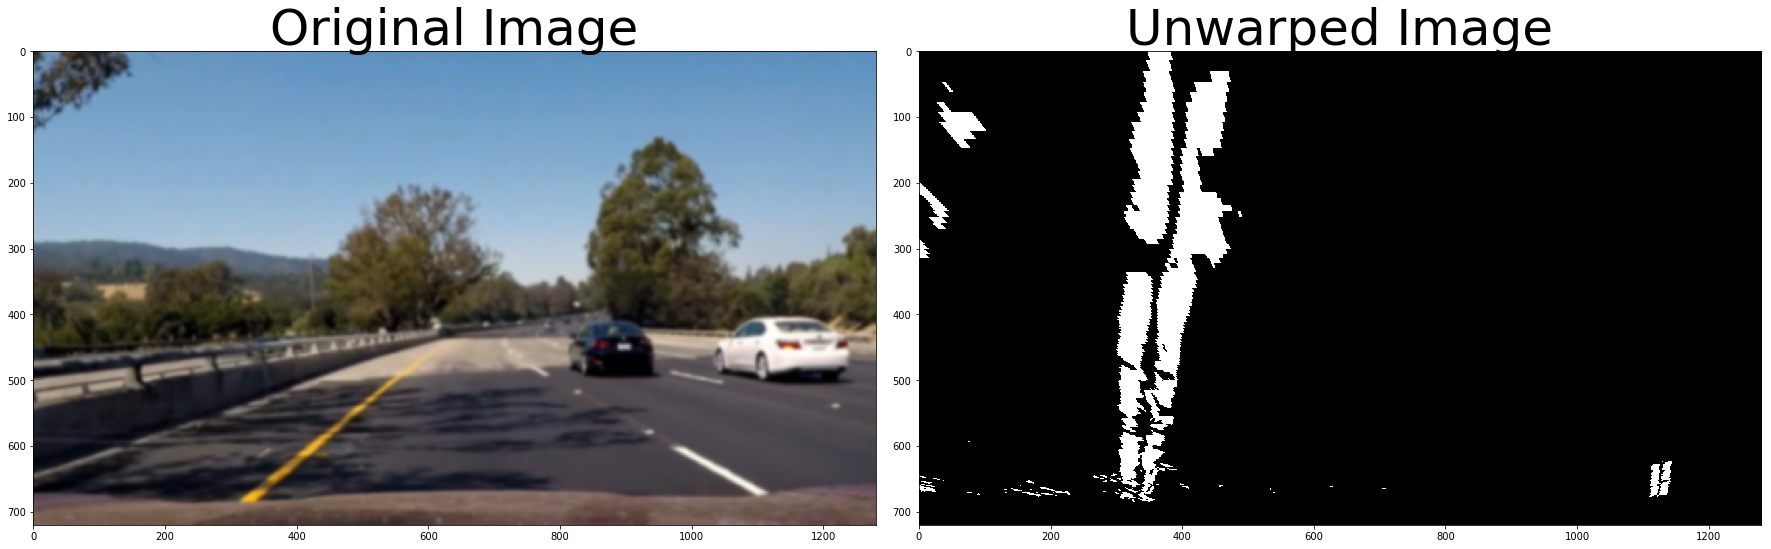

In [61]:
binary_warped = util.warper(combined3, src, dst)
util.pltPairedShow(img, 'Original Image', binary_warped, 'Unwarped Image')

### Detect lane pixels and fit to find the lane boundary

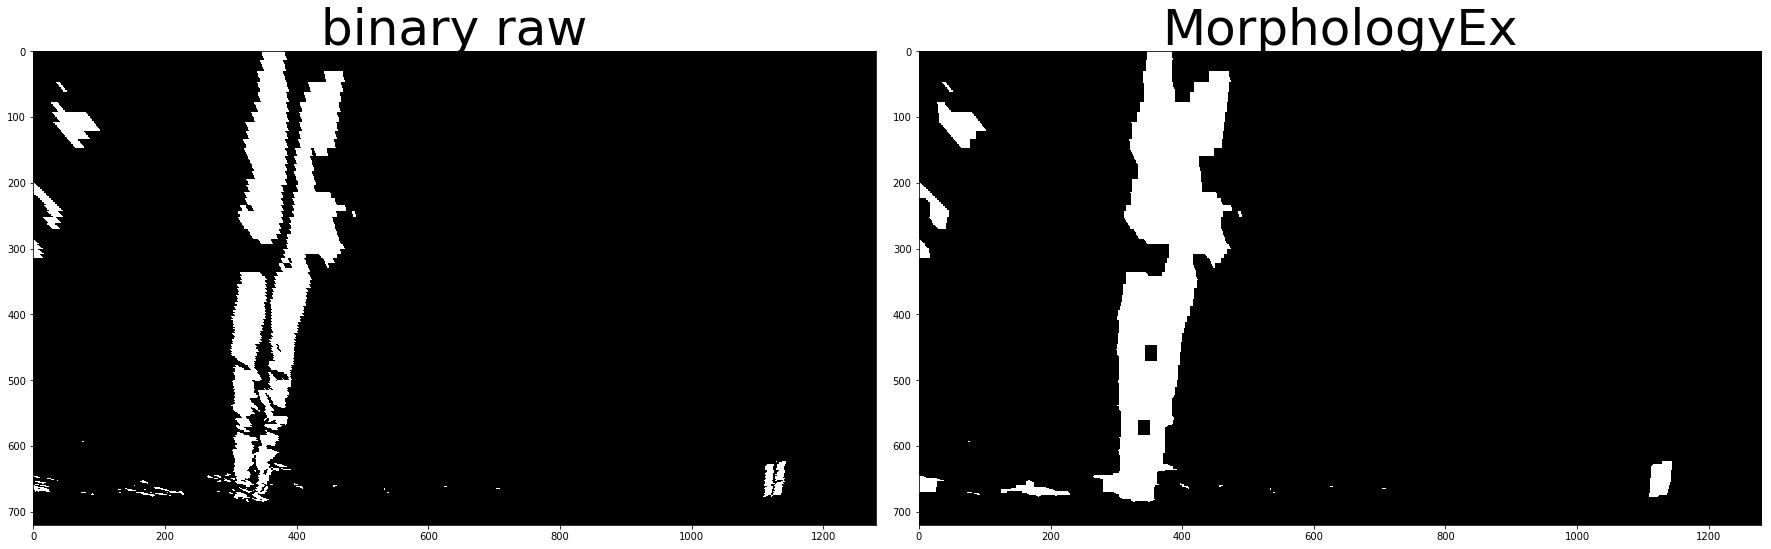

In [62]:
kernel = np.ones((17,19),np.uint8)

closing = cv2.morphologyEx(binary_warped, cv2.MORPH_CLOSE, kernel)

util.pltPairedShow(binary_warped, 'binary raw', closing, 'MorphologyEx')

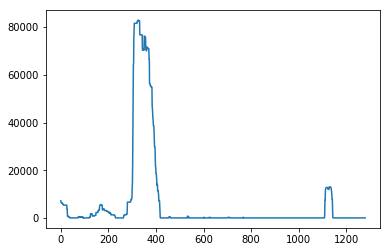

In [63]:
histogram = np.sum(closing[closing.shape[0]/2:,:], axis=0)
plt.plot(histogram)
plt.show()


In [64]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(closing[closing.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((closing, closing, closing))
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
#
confident_left = histogram[leftx_base] / (histogram[leftx_base] + histogram[rightx_base])
confident_right = histogram[rightx_base] / (histogram[leftx_base] + histogram[rightx_base])

primary_side = 'right'
if confident_left>confident_right:
    primary_side='left'
distance = rightx_base-leftx_base
if distance<700 | distance >900:
    distance = 700

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = closing.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = closing.shape[0] - (window+1)*window_height
    win_y_high = closing.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

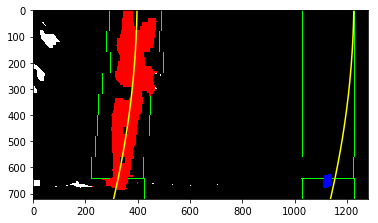

In [65]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = left_fitx +829

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

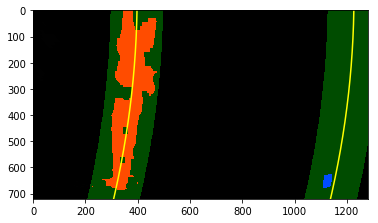

In [66]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

### Determine the curvature of the lane and vehicle position with respect to center.


In [67]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

3618.83633988 60326.6828832


In [68]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print("Left curv {:.2f}m, right curv {:.2f}m".format(left_curverad, right_curverad))
# Example values: 632.1 m    626.2 m

Left curv 1100.75m, right curv 1100.75m


### Warp the detected lane boundaries back onto the original image.


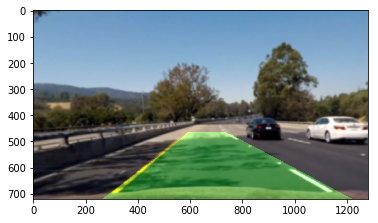

In [69]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()

### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [70]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

fontFace = cv2.FONT_HERSHEY_SIMPLEX
fontScale=1
thickness=2
    
def process_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = util.gaussian_blur(image, 3)
    undistorted = util.cal_undistort(image, objpoints, imgpoints)
    combined = util.combinedThresholds(undistorted)
    
    binary_warped = util.warper(combined, src, dst)
    closing = cv2.morphologyEx(binary_warped, cv2.MORPH_CLOSE, kernel)

    global left_fitx
    global right_fitx
    
    left_fitx, right_fitx, left_curverad, right_curverad, out_img = util.fitlines(closing, left_fitx, right_fitx)

    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    middle = int((left_fitx[-1] + right_fitx[-1])//2)
    veh_pos = int(image.shape[1]//2)
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    dx = (veh_pos - middle)*xm_per_pix 
    
    #draw position lines    
    cv2.line(result, (veh_pos, 300), (veh_pos, 720), (255,0,0),5)
    cv2.line(result, (middle, 400), (middle, 720), (200,200,200),5)
    
    img_out=np.zeros((576,1280,3), dtype=np.uint8)
    img_out[0:576,0:1024,:] =cv2.resize(result,(1024,576))
    #b) Threshold
    img_out[0:288,1024:1280, 0] =cv2.resize(combined,(256,288))
    img_out[0:288,1024:1280, 1] =cv2.resize(combined,(256,288))
    img_out[0:288,1024:1280, 2] =cv2.resize(combined,(256,288))
    #c)Birds eye view
    img_out[310:576,1024:1280,:] =cv2.resize(out_img,(256,266))
#    global path
#    global counter
#    cv2.imwrite('images/{}/{}.jpg'.format(path, counter), image)
#    counter += 1
    
    #Write curvature and center in image
    TextL = "Left  curv: {:>.1f} km".format(left_curverad/1000)
    TextR = "Right curv: {:>.1f} km".format(right_curverad/1000)
    
    cv2.putText(img_out, TextL, (130,40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextR, (130,70), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out,'Position : %.2f m %s of center'%(abs(dx), 'left' if dx < 0 else 'right'),(50,110), 
                        fontFace, fontScale,(255,255,255),thickness,lineType = cv2.LINE_AA)

    cv2.putText(img_out, "Thresh. view", (1070,30), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, "Birds-eye view", (1080,305), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
    
    img_out = cv2.cvtColor(img_out, cv2.COLOR_RGB2BGR)
    return img_out

In [71]:
path='project'
counter = 1
left_fitx= [0,0,0]
right_fitx = [0,0,0]
white_output = 'videos_out/project_video.mp4'
clip1 = VideoFileClip("videos/project_video.mp4")
white_clip = clip1.fl_image(process_image)#.subclip(38,42) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

40306  -  9739
[MoviePy] >>>> Building video videos_out/project_video.mp4
[MoviePy] Writing video videos_out/project_video.mp4



  0%|          | 1/1261 [00:00<17:32,  1.20it/s]

40306  -  9739



  0%|          | 2/1261 [00:01<17:39,  1.19it/s]

37585  -  8973



  0%|          | 3/1261 [00:02<17:36,  1.19it/s]

37824  -  9169



  0%|          | 4/1261 [00:03<17:28,  1.20it/s]

35838  -  9791



  0%|          | 5/1261 [00:04<17:22,  1.20it/s]

40399  -  7916



  0%|          | 6/1261 [00:04<17:18,  1.21it/s]

40297  -  7312



  1%|          | 7/1261 [00:05<17:16,  1.21it/s]

41804  -  7150



  1%|          | 8/1261 [00:06<17:15,  1.21it/s]

35722  -  5093



  1%|          | 9/1261 [00:07<17:13,  1.21it/s]

39739  -  6618



  1%|          | 10/1261 [00:08<17:08,  1.22it/s]

37548  -  6523



  1%|          | 11/1261 [00:09<17:09,  1.21it/s]

35860  -  6459



  1%|          | 12/1261 [00:09<17:07,  1.22it/s]

39831  -  6617



  1%|          | 13/1261 [00:10<17:10,  1.21it/s]

39893  -  6299



  1%|          | 14/1261 [00:11<17:15,  1.20it/s]

39496  -  6077



  1%|          | 15/1261 [00:12<17:17,  1.20it/s]

39354  -  5864



  1%|▏         | 16/1261 [00:13<17:16,  1.20it/s]

37592  -  5010



  1%|▏         | 17/1261 [00:14<17:14,  1.20it/s]

35942  -  5149



  1%|▏         | 18/1261 [00:14<17:10,  1.21it/s]

40312  -  7289



  2%|▏         | 19/1261 [00:15<17:44,  1.17it/s]

39896  -  6349



  2%|▏         | 20/1261 [00:16<17:37,  1.17it/s]

42694  -  6087



  2%|▏         | 21/1261 [00:17<17:28,  1.18it/s]

43420  -  6056



  2%|▏         | 22/1261 [00:18<17:16,  1.20it/s]

46501  -  6527



  2%|▏         | 23/1261 [00:19<17:21,  1.19it/s]

46381  -  6569



  2%|▏         | 24/1261 [00:19<17:09,  1.20it/s]

42875  -  6546



  2%|▏         | 25/1261 [00:20<17:08,  1.20it/s]

42533  -  6231



  2%|▏         | 26/1261 [00:21<17:12,  1.20it/s]

45001  -  5826



  2%|▏         | 27/1261 [00:22<17:09,  1.20it/s]

46089  -  5602



  2%|▏         | 28/1261 [00:23<17:15,  1.19it/s]

51260  -  5406



  2%|▏         | 29/1261 [00:24<17:09,  1.20it/s]

48423  -  6034



  2%|▏         | 30/1261 [00:25<17:08,  1.20it/s]

46342  -  4785



  2%|▏         | 31/1261 [00:25<17:08,  1.20it/s]

40465  -  8037



  3%|▎         | 32/1261 [00:26<17:16,  1.19it/s]

38704  -  6110



  3%|▎         | 33/1261 [00:27<17:11,  1.19it/s]

40962  -  5027



  3%|▎         | 34/1261 [00:28<17:06,  1.20it/s]

39333  -  5805



  3%|▎         | 35/1261 [00:29<17:06,  1.19it/s]

40538  -  5125



  3%|▎         | 36/1261 [00:30<17:05,  1.19it/s]

36772  -  5615



  3%|▎         | 37/1261 [00:30<17:06,  1.19it/s]

37859  -  6001



  3%|▎         | 38/1261 [00:31<17:01,  1.20it/s]

34664  -  5539



  3%|▎         | 39/1261 [00:32<17:03,  1.19it/s]

36467  -  5122



  3%|▎         | 40/1261 [00:33<16:59,  1.20it/s]

36368  -  4911



  3%|▎         | 41/1261 [00:34<16:57,  1.20it/s]

37304  -  5162



  3%|▎         | 42/1261 [00:35<16:52,  1.20it/s]

37127  -  5218



  3%|▎         | 43/1261 [00:35<16:55,  1.20it/s]

33926  -  4025



  3%|▎         | 44/1261 [00:36<16:59,  1.19it/s]

33809  -  3556



  4%|▎         | 45/1261 [00:37<17:04,  1.19it/s]

32348  -  4527



  4%|▎         | 46/1261 [00:38<17:09,  1.18it/s]

32507  -  6176



  4%|▎         | 47/1261 [00:39<17:04,  1.19it/s]

32247  -  6631



  4%|▍         | 48/1261 [00:40<16:56,  1.19it/s]

32840  -  6276



  4%|▍         | 49/1261 [00:40<16:56,  1.19it/s]

38244  -  6677



  4%|▍         | 50/1261 [00:41<16:57,  1.19it/s]

35364  -  6364



  4%|▍         | 51/1261 [00:42<16:54,  1.19it/s]

36276  -  5954



  4%|▍         | 52/1261 [00:43<16:51,  1.20it/s]

39514  -  5368



  4%|▍         | 53/1261 [00:44<16:47,  1.20it/s]

40114  -  5028



  4%|▍         | 54/1261 [00:45<16:52,  1.19it/s]

44363  -  4723



  4%|▍         | 55/1261 [00:45<16:45,  1.20it/s]

47392  -  4784



  4%|▍         | 56/1261 [00:46<16:49,  1.19it/s]

46999  -  4921



  5%|▍         | 57/1261 [00:47<16:49,  1.19it/s]

44337  -  4010



  5%|▍         | 58/1261 [00:48<16:42,  1.20it/s]

41295  -  5577



  5%|▍         | 59/1261 [00:49<16:36,  1.21it/s]

40339  -  5724



  5%|▍         | 60/1261 [00:50<16:44,  1.20it/s]

43877  -  5701



  5%|▍         | 61/1261 [00:50<16:42,  1.20it/s]

37839  -  6771



  5%|▍         | 62/1261 [00:51<16:43,  1.19it/s]

38450  -  6721



  5%|▍         | 63/1261 [00:52<16:41,  1.20it/s]

40633  -  6511



  5%|▌         | 64/1261 [00:53<16:42,  1.19it/s]

42025  -  6458



  5%|▌         | 65/1261 [00:54<16:40,  1.20it/s]

41464  -  6756



  5%|▌         | 66/1261 [00:55<16:40,  1.19it/s]

41727  -  7103



  5%|▌         | 67/1261 [00:56<16:48,  1.18it/s]

44501  -  7815



  5%|▌         | 68/1261 [00:56<16:40,  1.19it/s]

49381  -  5985



  5%|▌         | 69/1261 [00:57<16:38,  1.19it/s]

46872  -  6558



  6%|▌         | 70/1261 [00:58<16:31,  1.20it/s]

51253  -  4896



  6%|▌         | 71/1261 [00:59<16:42,  1.19it/s]

49654  -  4946



  6%|▌         | 72/1261 [01:00<16:40,  1.19it/s]

50263  -  5472



  6%|▌         | 73/1261 [01:01<16:32,  1.20it/s]

51735  -  5784



  6%|▌         | 74/1261 [01:01<16:28,  1.20it/s]

49020  -  5553



  6%|▌         | 75/1261 [01:02<16:34,  1.19it/s]

53535  -  5835



  6%|▌         | 76/1261 [01:03<16:31,  1.20it/s]

52075  -  5487



  6%|▌         | 77/1261 [01:04<16:37,  1.19it/s]

53966  -  5386



  6%|▌         | 78/1261 [01:05<16:32,  1.19it/s]

57541  -  5888



  6%|▋         | 79/1261 [01:06<16:28,  1.20it/s]

62001  -  7281



  6%|▋         | 80/1261 [01:06<16:26,  1.20it/s]

59104  -  7958



  6%|▋         | 81/1261 [01:07<16:21,  1.20it/s]

63044  -  7854



  7%|▋         | 82/1261 [01:08<16:19,  1.20it/s]

58434  -  6572



  7%|▋         | 83/1261 [01:09<16:20,  1.20it/s]

59958  -  5628



  7%|▋         | 84/1261 [01:10<16:31,  1.19it/s]

62014  -  6098



  7%|▋         | 85/1261 [01:11<16:26,  1.19it/s]

59258  -  5960



  7%|▋         | 86/1261 [01:11<16:27,  1.19it/s]

59018  -  6255



  7%|▋         | 87/1261 [01:12<16:25,  1.19it/s]

53449  -  6041



  7%|▋         | 88/1261 [01:13<16:15,  1.20it/s]

55430  -  6224



  7%|▋         | 89/1261 [01:14<16:17,  1.20it/s]

53239  -  5497



  7%|▋         | 90/1261 [01:15<16:13,  1.20it/s]

50190  -  5753



  7%|▋         | 91/1261 [01:16<16:21,  1.19it/s]

52490  -  9543



  7%|▋         | 92/1261 [01:16<16:24,  1.19it/s]

55181  -  10558



  7%|▋         | 93/1261 [01:17<16:31,  1.18it/s]

54506  -  9469



  7%|▋         | 94/1261 [01:18<16:30,  1.18it/s]

55127  -  8162



  8%|▊         | 95/1261 [01:19<16:33,  1.17it/s]

56617  -  7110



  8%|▊         | 96/1261 [01:20<16:35,  1.17it/s]

57647  -  5940



  8%|▊         | 97/1261 [01:21<16:29,  1.18it/s]

55118  -  5644



  8%|▊         | 98/1261 [01:22<16:17,  1.19it/s]

54173  -  5992



  8%|▊         | 99/1261 [01:22<16:13,  1.19it/s]

53321  -  5903



  8%|▊         | 100/1261 [01:23<16:05,  1.20it/s]

52524  -  6076



  8%|▊         | 101/1261 [01:24<16:04,  1.20it/s]

53083  -  5995



  8%|▊         | 102/1261 [01:25<16:02,  1.20it/s]

53380  -  5686



  8%|▊         | 103/1261 [01:26<16:01,  1.20it/s]

52056  -  5822



  8%|▊         | 104/1261 [01:27<16:05,  1.20it/s]

49022  -  5847



  8%|▊         | 105/1261 [01:27<15:59,  1.20it/s]

51557  -  7827



  8%|▊         | 106/1261 [01:28<16:04,  1.20it/s]

51522  -  7879



  8%|▊         | 107/1261 [01:29<16:06,  1.19it/s]

52488  -  6788



  9%|▊         | 108/1261 [01:30<16:13,  1.18it/s]

53533  -  6205



  9%|▊         | 109/1261 [01:31<16:06,  1.19it/s]

52203  -  6110



  9%|▊         | 110/1261 [01:32<15:59,  1.20it/s]

50378  -  6456



  9%|▉         | 111/1261 [01:32<15:53,  1.21it/s]

50109  -  6569



  9%|▉         | 112/1261 [01:33<15:51,  1.21it/s]

51821  -  6253



  9%|▉         | 113/1261 [01:34<15:50,  1.21it/s]

46057  -  6079



  9%|▉         | 114/1261 [01:35<16:01,  1.19it/s]

50763  -  5653



  9%|▉         | 115/1261 [01:36<16:05,  1.19it/s]

44236  -  5252



  9%|▉         | 116/1261 [01:37<16:07,  1.18it/s]

44274  -  6418



  9%|▉         | 117/1261 [01:37<16:02,  1.19it/s]

44091  -  5552



  9%|▉         | 118/1261 [01:38<16:08,  1.18it/s]

41059  -  4930



  9%|▉         | 119/1261 [01:39<16:06,  1.18it/s]

45018  -  5351



 10%|▉         | 120/1261 [01:40<16:04,  1.18it/s]

43442  -  4401



 10%|▉         | 121/1261 [01:41<16:08,  1.18it/s]

40405  -  5829



 10%|▉         | 122/1261 [01:42<15:58,  1.19it/s]

40190  -  5982



 10%|▉         | 123/1261 [01:42<15:52,  1.20it/s]

39619  -  5564



 10%|▉         | 124/1261 [01:43<15:47,  1.20it/s]

37555  -  5630



 10%|▉         | 125/1261 [01:44<15:39,  1.21it/s]

37815  -  5627



 10%|▉         | 126/1261 [01:45<15:44,  1.20it/s]

39021  -  5546



 10%|█         | 127/1261 [01:46<15:43,  1.20it/s]

38832  -  5249



 10%|█         | 128/1261 [01:47<15:37,  1.21it/s]

37387  -  4925



 10%|█         | 129/1261 [01:47<15:40,  1.20it/s]

39421  -  5832



 10%|█         | 130/1261 [01:48<15:40,  1.20it/s]

38238  -  5990



 10%|█         | 131/1261 [01:49<15:38,  1.20it/s]

38336  -  4886



 10%|█         | 132/1261 [01:50<15:45,  1.19it/s]

38699  -  5049



 11%|█         | 133/1261 [01:51<15:45,  1.19it/s]

39498  -  5276



 11%|█         | 134/1261 [01:52<15:48,  1.19it/s]

39694  -  4880



 11%|█         | 135/1261 [01:52<15:52,  1.18it/s]

41633  -  5436



 11%|█         | 136/1261 [01:53<15:45,  1.19it/s]

41054  -  5871



 11%|█         | 137/1261 [01:54<15:40,  1.20it/s]

39445  -  5975



 11%|█         | 138/1261 [01:55<15:40,  1.19it/s]

42717  -  6109



 11%|█         | 139/1261 [01:56<15:48,  1.18it/s]

42892  -  5730



 11%|█         | 140/1261 [01:57<15:44,  1.19it/s]

44775  -  5434



 11%|█         | 141/1261 [01:58<15:37,  1.20it/s]

42664  -  5552



 11%|█▏        | 142/1261 [01:58<15:31,  1.20it/s]

43309  -  7999



 11%|█▏        | 143/1261 [01:59<15:32,  1.20it/s]

45796  -  7755



 11%|█▏        | 144/1261 [02:00<15:31,  1.20it/s]

45426  -  5798



 11%|█▏        | 145/1261 [02:01<15:31,  1.20it/s]

49451  -  5664



 12%|█▏        | 146/1261 [02:02<15:37,  1.19it/s]

50036  -  5734



 12%|█▏        | 147/1261 [02:03<15:40,  1.19it/s]

51147  -  6092



 12%|█▏        | 148/1261 [02:03<15:34,  1.19it/s]

46931  -  5503



 12%|█▏        | 149/1261 [02:04<15:34,  1.19it/s]

44333  -  5825



 12%|█▏        | 150/1261 [02:05<15:35,  1.19it/s]

42663  -  5890



 12%|█▏        | 151/1261 [02:06<15:35,  1.19it/s]

46041  -  5932



 12%|█▏        | 152/1261 [02:07<15:26,  1.20it/s]

48755  -  5354



 12%|█▏        | 153/1261 [02:08<15:22,  1.20it/s]

47387  -  4998



 12%|█▏        | 154/1261 [02:08<15:21,  1.20it/s]

51807  -  4870



 12%|█▏        | 155/1261 [02:09<15:21,  1.20it/s]

49276  -  4718



 12%|█▏        | 156/1261 [02:10<15:20,  1.20it/s]

51228  -  3718



 12%|█▏        | 157/1261 [02:11<15:14,  1.21it/s]

51662  -  2920



 13%|█▎        | 158/1261 [02:12<15:14,  1.21it/s]

50772  -  3185



 13%|█▎        | 159/1261 [02:13<15:15,  1.20it/s]

51910  -  3042



 13%|█▎        | 160/1261 [02:13<15:14,  1.20it/s]

48814  -  4179



 13%|█▎        | 161/1261 [02:14<15:15,  1.20it/s]

47779  -  5000



 13%|█▎        | 162/1261 [02:15<15:14,  1.20it/s]

50292  -  5619



 13%|█▎        | 163/1261 [02:16<15:13,  1.20it/s]

50080  -  5636



 13%|█▎        | 164/1261 [02:17<15:18,  1.19it/s]

47462  -  5309



 13%|█▎        | 165/1261 [02:18<15:18,  1.19it/s]

48029  -  5018



 13%|█▎        | 166/1261 [02:18<15:14,  1.20it/s]

48448  -  5214



 13%|█▎        | 167/1261 [02:19<15:14,  1.20it/s]

45092  -  5655



 13%|█▎        | 168/1261 [02:20<15:15,  1.19it/s]

45283  -  4825



 13%|█▎        | 169/1261 [02:21<15:13,  1.19it/s]

48579  -  5122



 13%|█▎        | 170/1261 [02:22<15:11,  1.20it/s]

47202  -  5411



 14%|█▎        | 171/1261 [02:23<15:13,  1.19it/s]

52948  -  5652



 14%|█▎        | 172/1261 [02:23<15:18,  1.19it/s]

54151  -  6082



 14%|█▎        | 173/1261 [02:24<15:13,  1.19it/s]

54016  -  6138



 14%|█▍        | 174/1261 [02:25<15:12,  1.19it/s]

54732  -  5971



 14%|█▍        | 175/1261 [02:26<15:05,  1.20it/s]

51044  -  5773



 14%|█▍        | 176/1261 [02:27<15:07,  1.20it/s]

49504  -  5454



 14%|█▍        | 177/1261 [02:28<15:01,  1.20it/s]

54168  -  5284



 14%|█▍        | 178/1261 [02:28<14:57,  1.21it/s]

52255  -  5137



 14%|█▍        | 179/1261 [02:29<14:56,  1.21it/s]

51503  -  4818



 14%|█▍        | 180/1261 [02:30<14:57,  1.20it/s]

51263  -  4403



 14%|█▍        | 181/1261 [02:31<15:00,  1.20it/s]

44710  -  6907



 14%|█▍        | 182/1261 [02:32<15:03,  1.19it/s]

46817  -  6269



 15%|█▍        | 183/1261 [02:33<15:05,  1.19it/s]

47231  -  5103



 15%|█▍        | 184/1261 [02:33<15:05,  1.19it/s]

48121  -  3956



 15%|█▍        | 185/1261 [02:34<15:10,  1.18it/s]

50837  -  4695



 15%|█▍        | 186/1261 [02:35<15:06,  1.19it/s]

48207  -  4995



 15%|█▍        | 187/1261 [02:36<15:06,  1.18it/s]

44200  -  5293



 15%|█▍        | 188/1261 [02:37<14:59,  1.19it/s]

43334  -  5181



 15%|█▍        | 189/1261 [02:38<15:02,  1.19it/s]

42585  -  5084



 15%|█▌        | 190/1261 [02:38<14:58,  1.19it/s]

42921  -  4900



 15%|█▌        | 191/1261 [02:39<14:59,  1.19it/s]

40528  -  4494



 15%|█▌        | 192/1261 [02:40<15:05,  1.18it/s]

38608  -  4214



 15%|█▌        | 193/1261 [02:41<15:04,  1.18it/s]

40025  -  3602



 15%|█▌        | 194/1261 [02:42<15:05,  1.18it/s]

39447  -  4279



 15%|█▌        | 195/1261 [02:43<14:54,  1.19it/s]

36291  -  4127



 16%|█▌        | 196/1261 [02:44<15:13,  1.17it/s]

44972  -  4675



 16%|█▌        | 197/1261 [02:44<15:06,  1.17it/s]

48795  -  5307



 16%|█▌        | 198/1261 [02:45<15:00,  1.18it/s]

52091  -  6187



 16%|█▌        | 199/1261 [02:46<14:52,  1.19it/s]

55118  -  6620



 16%|█▌        | 200/1261 [02:47<14:45,  1.20it/s]

58119  -  6611



 16%|█▌        | 201/1261 [02:48<14:45,  1.20it/s]

55492  -  6097



 16%|█▌        | 202/1261 [02:49<14:45,  1.20it/s]

57196  -  5510



 16%|█▌        | 203/1261 [02:49<14:40,  1.20it/s]

56957  -  5188



 16%|█▌        | 204/1261 [02:50<14:35,  1.21it/s]

56881  -  4815



 16%|█▋        | 205/1261 [02:51<14:31,  1.21it/s]

54753  -  4725



 16%|█▋        | 206/1261 [02:52<14:32,  1.21it/s]

51655  -  5147



 16%|█▋        | 207/1261 [02:53<14:29,  1.21it/s]

48401  -  4840



 16%|█▋        | 208/1261 [02:54<14:26,  1.22it/s]

46745  -  4807



 17%|█▋        | 209/1261 [02:54<14:23,  1.22it/s]

49447  -  5279



 17%|█▋        | 210/1261 [02:55<14:27,  1.21it/s]

51361  -  5544



 17%|█▋        | 211/1261 [02:56<14:29,  1.21it/s]

46651  -  6176



 17%|█▋        | 212/1261 [02:57<14:25,  1.21it/s]

47389  -  5870



 17%|█▋        | 213/1261 [02:58<14:24,  1.21it/s]

49113  -  5656



 17%|█▋        | 214/1261 [02:58<14:23,  1.21it/s]

48561  -  5509



 17%|█▋        | 215/1261 [02:59<14:25,  1.21it/s]

47401  -  5523



 17%|█▋        | 216/1261 [03:00<14:27,  1.21it/s]

52099  -  5811



 17%|█▋        | 217/1261 [03:01<14:24,  1.21it/s]

46458  -  5939



 17%|█▋        | 218/1261 [03:02<14:25,  1.20it/s]

50739  -  5502



 17%|█▋        | 219/1261 [03:03<14:23,  1.21it/s]

50640  -  6367



 17%|█▋        | 220/1261 [03:03<14:20,  1.21it/s]

51961  -  5019



 18%|█▊        | 221/1261 [03:04<14:24,  1.20it/s]

51655  -  5934



 18%|█▊        | 222/1261 [03:05<14:32,  1.19it/s]

49657  -  6271



 18%|█▊        | 223/1261 [03:06<14:32,  1.19it/s]

52144  -  6500



 18%|█▊        | 224/1261 [03:07<14:32,  1.19it/s]

50215  -  6078



 18%|█▊        | 225/1261 [03:08<14:24,  1.20it/s]

51281  -  5974



 18%|█▊        | 226/1261 [03:09<14:23,  1.20it/s]

51984  -  5435



 18%|█▊        | 227/1261 [03:09<14:23,  1.20it/s]

53694  -  5170



 18%|█▊        | 228/1261 [03:10<14:34,  1.18it/s]

56676  -  8154



 18%|█▊        | 229/1261 [03:11<14:34,  1.18it/s]

57415  -  9254



 18%|█▊        | 230/1261 [03:12<14:29,  1.19it/s]

60128  -  7367



 18%|█▊        | 231/1261 [03:13<14:23,  1.19it/s]

57956  -  7571



 18%|█▊        | 232/1261 [03:14<14:28,  1.19it/s]

61860  -  6872



 18%|█▊        | 233/1261 [03:14<14:29,  1.18it/s]

58941  -  6009



 19%|█▊        | 234/1261 [03:15<14:31,  1.18it/s]

61512  -  5912



 19%|█▊        | 235/1261 [03:16<14:26,  1.18it/s]

58331  -  6054



 19%|█▊        | 236/1261 [03:17<14:25,  1.18it/s]

58040  -  5582



 19%|█▉        | 237/1261 [03:18<14:16,  1.20it/s]

57417  -  5492



 19%|█▉        | 238/1261 [03:19<14:23,  1.18it/s]

58985  -  5265



 19%|█▉        | 239/1261 [03:19<14:18,  1.19it/s]

61925  -  5099



 19%|█▉        | 240/1261 [03:20<14:16,  1.19it/s]

58463  -  5757



 19%|█▉        | 241/1261 [03:21<14:12,  1.20it/s]

59493  -  9378



 19%|█▉        | 242/1261 [03:22<14:09,  1.20it/s]

60439  -  8576



 19%|█▉        | 243/1261 [03:23<14:04,  1.20it/s]

58447  -  7267



 19%|█▉        | 244/1261 [03:24<14:02,  1.21it/s]

57831  -  6209



 19%|█▉        | 245/1261 [03:24<14:07,  1.20it/s]

57988  -  5364



 20%|█▉        | 246/1261 [03:25<14:08,  1.20it/s]

57368  -  5659



 20%|█▉        | 247/1261 [03:26<14:12,  1.19it/s]

59314  -  5776



 20%|█▉        | 248/1261 [03:27<14:09,  1.19it/s]

60951  -  5654



 20%|█▉        | 249/1261 [03:28<14:03,  1.20it/s]

64472  -  5629



 20%|█▉        | 250/1261 [03:29<14:00,  1.20it/s]

64842  -  5313



 20%|█▉        | 251/1261 [03:29<13:56,  1.21it/s]

64187  -  5135



 20%|█▉        | 252/1261 [03:30<14:00,  1.20it/s]

62580  -  5373



 20%|██        | 253/1261 [03:31<13:58,  1.20it/s]

62539  -  5159



 20%|██        | 254/1261 [03:32<13:57,  1.20it/s]

63153  -  5353



 20%|██        | 255/1261 [03:33<13:54,  1.21it/s]

59758  -  4862



 20%|██        | 256/1261 [03:34<13:53,  1.21it/s]

61438  -  3908



 20%|██        | 257/1261 [03:34<13:50,  1.21it/s]

59726  -  4180



 20%|██        | 258/1261 [03:35<13:59,  1.19it/s]

59789  -  4978



 21%|██        | 259/1261 [03:36<13:54,  1.20it/s]

60149  -  5105



 21%|██        | 260/1261 [03:37<13:48,  1.21it/s]

61776  -  5294



 21%|██        | 261/1261 [03:38<13:45,  1.21it/s]

61635  -  5606



 21%|██        | 262/1261 [03:39<13:45,  1.21it/s]

62283  -  5329



 21%|██        | 263/1261 [03:39<13:41,  1.22it/s]

62565  -  5466



 21%|██        | 264/1261 [03:40<13:45,  1.21it/s]

64509  -  7107



 21%|██        | 265/1261 [03:41<13:47,  1.20it/s]

65081  -  9835



 21%|██        | 266/1261 [03:42<13:52,  1.19it/s]

66179  -  9697



 21%|██        | 267/1261 [03:43<13:47,  1.20it/s]

63840  -  7677



 21%|██▏       | 268/1261 [03:44<13:48,  1.20it/s]

61522  -  7314



 21%|██▏       | 269/1261 [03:44<13:42,  1.21it/s]

61886  -  6812



 21%|██▏       | 270/1261 [03:45<13:45,  1.20it/s]

61178  -  6172



 21%|██▏       | 271/1261 [03:46<13:39,  1.21it/s]

59860  -  6746



 22%|██▏       | 272/1261 [03:47<13:42,  1.20it/s]

60202  -  6563



 22%|██▏       | 273/1261 [03:48<13:48,  1.19it/s]

62522  -  7409



 22%|██▏       | 274/1261 [03:49<13:47,  1.19it/s]

61005  -  6354



 22%|██▏       | 275/1261 [03:49<13:40,  1.20it/s]

63640  -  7739



 22%|██▏       | 276/1261 [03:50<13:38,  1.20it/s]

63859  -  7894



 22%|██▏       | 277/1261 [03:51<13:39,  1.20it/s]

63946  -  9142



 22%|██▏       | 278/1261 [03:52<13:35,  1.21it/s]

63124  -  8113



 22%|██▏       | 279/1261 [03:53<13:37,  1.20it/s]

62043  -  6970



 22%|██▏       | 280/1261 [03:54<13:44,  1.19it/s]

62573  -  5762



 22%|██▏       | 281/1261 [03:54<13:44,  1.19it/s]

64814  -  5260



 22%|██▏       | 282/1261 [03:55<13:50,  1.18it/s]

60679  -  5271



 22%|██▏       | 283/1261 [03:56<13:47,  1.18it/s]

64731  -  5797



 23%|██▎       | 284/1261 [03:57<13:46,  1.18it/s]

62423  -  5712



 23%|██▎       | 285/1261 [03:58<13:43,  1.19it/s]

65686  -  5917



 23%|██▎       | 286/1261 [03:59<13:46,  1.18it/s]

68659  -  5955



 23%|██▎       | 287/1261 [04:00<13:40,  1.19it/s]

67793  -  6597



 23%|██▎       | 288/1261 [04:00<13:36,  1.19it/s]

68505  -  6927



 23%|██▎       | 289/1261 [04:01<13:30,  1.20it/s]

67065  -  8630



 23%|██▎       | 290/1261 [04:02<13:27,  1.20it/s]

66785  -  8748



 23%|██▎       | 291/1261 [04:03<13:29,  1.20it/s]

67080  -  6950



 23%|██▎       | 292/1261 [04:04<13:29,  1.20it/s]

63941  -  5891



 23%|██▎       | 293/1261 [04:05<13:33,  1.19it/s]

64479  -  5462



 23%|██▎       | 294/1261 [04:05<13:35,  1.19it/s]

64054  -  5754



 23%|██▎       | 295/1261 [04:06<13:39,  1.18it/s]

63722  -  5881



 23%|██▎       | 296/1261 [04:07<13:35,  1.18it/s]

64865  -  5763



 24%|██▎       | 297/1261 [04:08<13:32,  1.19it/s]

66408  -  5698



 24%|██▎       | 298/1261 [04:09<13:36,  1.18it/s]

65895  -  5993



 24%|██▎       | 299/1261 [04:10<13:27,  1.19it/s]

66452  -  6284



 24%|██▍       | 300/1261 [04:10<13:27,  1.19it/s]

66766  -  6302



 24%|██▍       | 301/1261 [04:11<13:22,  1.20it/s]

63844  -  8991



 24%|██▍       | 302/1261 [04:12<13:21,  1.20it/s]

66215  -  7966



 24%|██▍       | 303/1261 [04:13<13:18,  1.20it/s]

65967  -  6911



 24%|██▍       | 304/1261 [04:14<13:23,  1.19it/s]

65357  -  6090



 24%|██▍       | 305/1261 [04:15<13:25,  1.19it/s]

67638  -  5895



 24%|██▍       | 306/1261 [04:15<13:24,  1.19it/s]

65431  -  5688



 24%|██▍       | 307/1261 [04:16<13:20,  1.19it/s]

67098  -  6038



 24%|██▍       | 308/1261 [04:17<13:18,  1.19it/s]

67580  -  5526



 25%|██▍       | 309/1261 [04:18<13:17,  1.19it/s]

69482  -  5407



 25%|██▍       | 310/1261 [04:19<13:10,  1.20it/s]

68264  -  5159



 25%|██▍       | 311/1261 [04:20<13:07,  1.21it/s]

69086  -  5005



 25%|██▍       | 312/1261 [04:20<13:08,  1.20it/s]

70116  -  5456



 25%|██▍       | 313/1261 [04:21<13:06,  1.21it/s]

68486  -  5451



 25%|██▍       | 314/1261 [04:22<13:11,  1.20it/s]

69621  -  6975



 25%|██▍       | 315/1261 [04:23<13:15,  1.19it/s]

70586  -  5672



 25%|██▌       | 316/1261 [04:24<13:18,  1.18it/s]

71472  -  5590



 25%|██▌       | 317/1261 [04:25<13:12,  1.19it/s]

70478  -  5353



 25%|██▌       | 318/1261 [04:25<13:07,  1.20it/s]

69380  -  5271



 25%|██▌       | 319/1261 [04:26<13:04,  1.20it/s]

68757  -  5619



 25%|██▌       | 320/1261 [04:27<13:01,  1.20it/s]

68871  -  5503



 25%|██▌       | 321/1261 [04:28<13:01,  1.20it/s]

69157  -  5379



 26%|██▌       | 322/1261 [04:29<12:59,  1.21it/s]

69981  -  5160



 26%|██▌       | 323/1261 [04:30<13:07,  1.19it/s]

70027  -  4960



 26%|██▌       | 324/1261 [04:30<13:02,  1.20it/s]

70499  -  5183



 26%|██▌       | 325/1261 [04:31<13:03,  1.19it/s]

70429  -  5824



 26%|██▌       | 326/1261 [04:32<13:03,  1.19it/s]

69282  -  6029



 26%|██▌       | 327/1261 [04:33<13:13,  1.18it/s]

69955  -  5905



 26%|██▌       | 328/1261 [04:34<13:20,  1.16it/s]

70257  -  4790



 26%|██▌       | 329/1261 [04:35<13:16,  1.17it/s]

70617  -  5102



 26%|██▌       | 330/1261 [04:36<13:11,  1.18it/s]

69269  -  5432



 26%|██▌       | 331/1261 [04:36<13:06,  1.18it/s]

68392  -  6585



 26%|██▋       | 332/1261 [04:37<13:06,  1.18it/s]

68209  -  6276



 26%|██▋       | 333/1261 [04:38<13:03,  1.18it/s]

69239  -  6494



 26%|██▋       | 334/1261 [04:39<13:03,  1.18it/s]

69958  -  5421



 27%|██▋       | 335/1261 [04:40<12:56,  1.19it/s]

70733  -  6589



 27%|██▋       | 336/1261 [04:41<12:57,  1.19it/s]

70732  -  7067



 27%|██▋       | 337/1261 [04:41<12:59,  1.19it/s]

69620  -  7399



 27%|██▋       | 338/1261 [04:42<13:00,  1.18it/s]

68530  -  7603



 27%|██▋       | 339/1261 [04:43<12:58,  1.18it/s]

70972  -  7275



 27%|██▋       | 340/1261 [04:44<12:57,  1.18it/s]

71083  -  5463



 27%|██▋       | 341/1261 [04:45<12:52,  1.19it/s]

70601  -  4594



 27%|██▋       | 342/1261 [04:46<12:56,  1.18it/s]

70773  -  4800



 27%|██▋       | 343/1261 [04:47<12:55,  1.18it/s]

70250  -  5729



 27%|██▋       | 344/1261 [04:47<12:49,  1.19it/s]

70490  -  5751



 27%|██▋       | 345/1261 [04:48<12:42,  1.20it/s]

69610  -  6089



 27%|██▋       | 346/1261 [04:49<12:44,  1.20it/s]

68350  -  6283



 28%|██▊       | 347/1261 [04:50<12:41,  1.20it/s]

68919  -  6201



 28%|██▊       | 348/1261 [04:51<12:37,  1.21it/s]

68858  -  7916



 28%|██▊       | 349/1261 [04:52<12:39,  1.20it/s]

67784  -  7700



 28%|██▊       | 350/1261 [04:52<12:38,  1.20it/s]

68013  -  7737



 28%|██▊       | 351/1261 [04:53<12:36,  1.20it/s]

68491  -  7929



 28%|██▊       | 352/1261 [04:54<12:33,  1.21it/s]

68583  -  6901



 28%|██▊       | 353/1261 [04:55<12:32,  1.21it/s]

67011  -  6253



 28%|██▊       | 354/1261 [04:56<12:36,  1.20it/s]

66988  -  6318



 28%|██▊       | 355/1261 [04:57<12:31,  1.21it/s]

66600  -  6296



 28%|██▊       | 356/1261 [04:57<12:33,  1.20it/s]

64874  -  6272



 28%|██▊       | 357/1261 [04:58<12:28,  1.21it/s]

63289  -  5923



 28%|██▊       | 358/1261 [04:59<12:34,  1.20it/s]

65110  -  5760



 28%|██▊       | 359/1261 [05:00<12:30,  1.20it/s]

66312  -  5981



 29%|██▊       | 360/1261 [05:01<12:41,  1.18it/s]

69147  -  9339



 29%|██▊       | 361/1261 [05:02<12:39,  1.19it/s]

62906  -  10516



 29%|██▊       | 362/1261 [05:02<12:40,  1.18it/s]

68721  -  9020



 29%|██▉       | 363/1261 [05:03<12:37,  1.19it/s]

68753  -  7774



 29%|██▉       | 364/1261 [05:04<12:36,  1.19it/s]

69843  -  6694



 29%|██▉       | 365/1261 [05:05<12:29,  1.20it/s]

70949  -  5718



 29%|██▉       | 366/1261 [05:06<12:32,  1.19it/s]

68893  -  5787



 29%|██▉       | 367/1261 [05:07<12:27,  1.20it/s]

69979  -  6163



 29%|██▉       | 368/1261 [05:07<12:34,  1.18it/s]

70506  -  6048



 29%|██▉       | 369/1261 [05:08<12:32,  1.19it/s]

70972  -  5837



 29%|██▉       | 370/1261 [05:09<12:33,  1.18it/s]

70909  -  6472



 29%|██▉       | 371/1261 [05:10<12:39,  1.17it/s]

70765  -  6431



 30%|██▉       | 372/1261 [05:11<12:31,  1.18it/s]

72094  -  6990



 30%|██▉       | 373/1261 [05:12<12:31,  1.18it/s]

70491  -  6249



 30%|██▉       | 374/1261 [05:13<12:29,  1.18it/s]

69650  -  6401



 30%|██▉       | 375/1261 [05:13<12:24,  1.19it/s]

68808  -  5944



 30%|██▉       | 376/1261 [05:14<12:26,  1.19it/s]

67480  -  5269



 30%|██▉       | 377/1261 [05:15<12:26,  1.18it/s]

68079  -  4611



 30%|██▉       | 378/1261 [05:16<12:23,  1.19it/s]

67167  -  4697



 30%|███       | 379/1261 [05:17<12:20,  1.19it/s]

68897  -  5529



 30%|███       | 380/1261 [05:18<12:20,  1.19it/s]

68307  -  5260



 30%|███       | 381/1261 [05:18<12:17,  1.19it/s]

67939  -  5476



 30%|███       | 382/1261 [05:19<12:22,  1.18it/s]

69621  -  5254



 30%|███       | 383/1261 [05:20<12:23,  1.18it/s]

68362  -  5062



 30%|███       | 384/1261 [05:21<12:21,  1.18it/s]

69108  -  6870



 31%|███       | 385/1261 [05:22<12:20,  1.18it/s]

69093  -  6856



 31%|███       | 386/1261 [05:23<12:18,  1.19it/s]

67757  -  8437



 31%|███       | 387/1261 [05:23<12:14,  1.19it/s]

68741  -  6747



 31%|███       | 388/1261 [05:24<12:14,  1.19it/s]

67070  -  7021



 31%|███       | 389/1261 [05:25<12:12,  1.19it/s]

67430  -  5910



 31%|███       | 390/1261 [05:26<12:09,  1.19it/s]

67188  -  6062



 31%|███       | 391/1261 [05:27<12:07,  1.20it/s]

63130  -  11066



 31%|███       | 392/1261 [05:28<12:10,  1.19it/s]

64793  -  10702



 31%|███       | 393/1261 [05:29<12:12,  1.19it/s]

67313  -  8434



 31%|███       | 394/1261 [05:29<12:12,  1.18it/s]

66994  -  7567



 31%|███▏      | 395/1261 [05:30<12:13,  1.18it/s]

66244  -  9246



 31%|███▏      | 396/1261 [05:31<12:16,  1.17it/s]

66213  -  9736



 31%|███▏      | 397/1261 [05:32<12:11,  1.18it/s]

65488  -  11210



 32%|███▏      | 398/1261 [05:33<12:05,  1.19it/s]

63613  -  9949



 32%|███▏      | 399/1261 [05:34<12:08,  1.18it/s]

61493  -  8681



 32%|███▏      | 400/1261 [05:35<12:20,  1.16it/s]

65315  -  7697



 32%|███▏      | 401/1261 [05:35<12:18,  1.16it/s]

65775  -  6581



 32%|███▏      | 402/1261 [05:36<12:13,  1.17it/s]

67689  -  6553



 32%|███▏      | 403/1261 [05:37<12:06,  1.18it/s]

68297  -  6837



 32%|███▏      | 404/1261 [05:38<12:03,  1.18it/s]

71089  -  6583



 32%|███▏      | 405/1261 [05:39<12:05,  1.18it/s]

72119  -  7679



 32%|███▏      | 406/1261 [05:40<12:08,  1.17it/s]

73024  -  7858



 32%|███▏      | 407/1261 [05:40<12:04,  1.18it/s]

72060  -  8521



 32%|███▏      | 408/1261 [05:41<12:02,  1.18it/s]

71476  -  9210



 32%|███▏      | 409/1261 [05:42<11:56,  1.19it/s]

72690  -  10076



 33%|███▎      | 410/1261 [05:43<11:52,  1.19it/s]

73122  -  9958



 33%|███▎      | 411/1261 [05:44<11:52,  1.19it/s]

72765  -  8610



 33%|███▎      | 412/1261 [05:45<11:48,  1.20it/s]

71297  -  7438



 33%|███▎      | 413/1261 [05:45<11:47,  1.20it/s]

71495  -  5681



 33%|███▎      | 414/1261 [05:46<12:07,  1.16it/s]

71615  -  6295



 33%|███▎      | 415/1261 [05:47<12:10,  1.16it/s]

71150  -  6435



 33%|███▎      | 416/1261 [05:48<12:00,  1.17it/s]

71957  -  7896



 33%|███▎      | 417/1261 [05:49<11:53,  1.18it/s]

70758  -  6667



 33%|███▎      | 418/1261 [05:50<11:47,  1.19it/s]

72306  -  7503



 33%|███▎      | 419/1261 [05:51<11:46,  1.19it/s]

69486  -  6657



 33%|███▎      | 420/1261 [05:51<11:41,  1.20it/s]

68467  -  5385



 33%|███▎      | 421/1261 [05:52<11:40,  1.20it/s]

67326  -  10609



 33%|███▎      | 422/1261 [05:53<11:38,  1.20it/s]

70439  -  8500



 34%|███▎      | 423/1261 [05:54<11:37,  1.20it/s]

71235  -  7532



 34%|███▎      | 424/1261 [05:55<11:34,  1.20it/s]

69995  -  6605



 34%|███▎      | 425/1261 [05:56<11:40,  1.19it/s]

69012  -  5835



 34%|███▍      | 426/1261 [05:56<11:45,  1.18it/s]

71261  -  5498



 34%|███▍      | 427/1261 [05:57<11:48,  1.18it/s]

74006  -  6293



 34%|███▍      | 428/1261 [05:58<11:48,  1.18it/s]

73058  -  6721



 34%|███▍      | 429/1261 [05:59<11:45,  1.18it/s]

74811  -  6692



 34%|███▍      | 430/1261 [06:00<11:44,  1.18it/s]

74633  -  6074



 34%|███▍      | 431/1261 [06:01<11:40,  1.19it/s]

73655  -  8536



 34%|███▍      | 432/1261 [06:01<11:41,  1.18it/s]

72245  -  9548



 34%|███▍      | 433/1261 [06:02<11:43,  1.18it/s]

72116  -  9929



 34%|███▍      | 434/1261 [06:03<11:39,  1.18it/s]

72712  -  9083



 34%|███▍      | 435/1261 [06:04<11:32,  1.19it/s]

72602  -  7641



 35%|███▍      | 436/1261 [06:05<11:39,  1.18it/s]

72234  -  6563



 35%|███▍      | 437/1261 [06:06<11:38,  1.18it/s]

74269  -  4917



 35%|███▍      | 438/1261 [06:07<11:32,  1.19it/s]

75741  -  5546



 35%|███▍      | 439/1261 [06:07<11:27,  1.20it/s]

75880  -  5408



 35%|███▍      | 440/1261 [06:08<11:26,  1.20it/s]

77103  -  5624



 35%|███▍      | 441/1261 [06:09<11:22,  1.20it/s]

72793  -  5503



 35%|███▌      | 442/1261 [06:10<11:27,  1.19it/s]

75307  -  7511



 35%|███▌      | 443/1261 [06:11<11:26,  1.19it/s]

75811  -  7927



 35%|███▌      | 444/1261 [06:12<11:31,  1.18it/s]

75730  -  8933



 35%|███▌      | 445/1261 [06:12<11:26,  1.19it/s]

76209  -  9577



 35%|███▌      | 446/1261 [06:13<11:24,  1.19it/s]

75702  -  8974



 35%|███▌      | 447/1261 [06:14<11:21,  1.19it/s]

77268  -  7557



 36%|███▌      | 448/1261 [06:15<11:20,  1.19it/s]

75902  -  6496



 36%|███▌      | 449/1261 [06:16<11:16,  1.20it/s]

74073  -  5214



 36%|███▌      | 450/1261 [06:17<11:15,  1.20it/s]

74275  -  5726



 36%|███▌      | 451/1261 [06:17<11:11,  1.21it/s]

71304  -  8827



 36%|███▌      | 452/1261 [06:18<11:10,  1.21it/s]

71817  -  8350



 36%|███▌      | 453/1261 [06:19<11:10,  1.21it/s]

74420  -  8077



 36%|███▌      | 454/1261 [06:20<11:10,  1.20it/s]

74044  -  8476



 36%|███▌      | 455/1261 [06:21<11:09,  1.20it/s]

77229  -  8936



 36%|███▌      | 456/1261 [06:22<11:11,  1.20it/s]

75607  -  8854



 36%|███▌      | 457/1261 [06:22<11:11,  1.20it/s]

74538  -  8736



 36%|███▋      | 458/1261 [06:23<11:12,  1.19it/s]

73721  -  7183



 36%|███▋      | 459/1261 [06:24<11:14,  1.19it/s]

74588  -  6278



 36%|███▋      | 460/1261 [06:25<11:14,  1.19it/s]

73480  -  5711



 37%|███▋      | 461/1261 [06:26<11:14,  1.19it/s]

75104  -  5462



 37%|███▋      | 462/1261 [06:27<11:14,  1.19it/s]

73369  -  6861



 37%|███▋      | 463/1261 [06:27<11:10,  1.19it/s]

74124  -  7908



 37%|███▋      | 464/1261 [06:28<11:07,  1.19it/s]

75044  -  7415



 37%|███▋      | 465/1261 [06:29<11:11,  1.19it/s]

72200  -  7922



 37%|███▋      | 466/1261 [06:30<11:13,  1.18it/s]

72885  -  8504



 37%|███▋      | 467/1261 [06:31<11:08,  1.19it/s]

72917  -  8586



 37%|███▋      | 468/1261 [06:32<11:09,  1.19it/s]

74509  -  9315



 37%|███▋      | 469/1261 [06:33<11:08,  1.18it/s]

73195  -  9681



 37%|███▋      | 470/1261 [06:33<11:03,  1.19it/s]

73360  -  9371



 37%|███▋      | 471/1261 [06:34<11:07,  1.18it/s]

72820  -  7510



 37%|███▋      | 472/1261 [06:35<11:08,  1.18it/s]

73445  -  6711



 38%|███▊      | 473/1261 [06:36<11:04,  1.19it/s]

74056  -  5581



 38%|███▊      | 474/1261 [06:37<11:07,  1.18it/s]

72205  -  5853



 38%|███▊      | 475/1261 [06:38<11:04,  1.18it/s]

71592  -  6207



 38%|███▊      | 476/1261 [06:38<10:58,  1.19it/s]

73157  -  6206



 38%|███▊      | 477/1261 [06:39<10:53,  1.20it/s]

74582  -  8279



 38%|███▊      | 478/1261 [06:40<10:52,  1.20it/s]

71197  -  8663



 38%|███▊      | 479/1261 [06:41<10:50,  1.20it/s]

69536  -  8149



 38%|███▊      | 480/1261 [06:42<10:49,  1.20it/s]

69210  -  10132



 38%|███▊      | 481/1261 [06:43<10:49,  1.20it/s]

64609  -  11204



 38%|███▊      | 482/1261 [06:43<10:45,  1.21it/s]

65572  -  10112



 38%|███▊      | 483/1261 [06:44<10:49,  1.20it/s]

68895  -  8250



 38%|███▊      | 484/1261 [06:45<10:51,  1.19it/s]

71247  -  6898



 38%|███▊      | 485/1261 [06:46<10:45,  1.20it/s]

72534  -  6343



 39%|███▊      | 486/1261 [06:47<10:45,  1.20it/s]

75108  -  6345



 39%|███▊      | 487/1261 [06:48<10:43,  1.20it/s]

75750  -  6121



 39%|███▊      | 488/1261 [06:48<10:40,  1.21it/s]

73147  -  5938



 39%|███▉      | 489/1261 [06:49<10:39,  1.21it/s]

74328  -  5840



 39%|███▉      | 490/1261 [06:50<10:39,  1.21it/s]

74155  -  5307



 39%|███▉      | 491/1261 [06:51<10:43,  1.20it/s]

75870  -  5976



 39%|███▉      | 492/1261 [06:52<10:42,  1.20it/s]

72980  -  7621



 39%|███▉      | 493/1261 [06:53<10:45,  1.19it/s]

72182  -  8089



 39%|███▉      | 494/1261 [06:53<10:46,  1.19it/s]

73219  -  8955



 39%|███▉      | 495/1261 [06:54<10:43,  1.19it/s]

73210  -  7795



 39%|███▉      | 496/1261 [06:55<10:41,  1.19it/s]

73210  -  6495



 39%|███▉      | 497/1261 [06:56<10:42,  1.19it/s]

72422  -  5686



 39%|███▉      | 498/1261 [06:57<10:40,  1.19it/s]

73736  -  5979



 40%|███▉      | 499/1261 [06:58<10:38,  1.19it/s]

71625  -  6327



 40%|███▉      | 500/1261 [06:58<10:33,  1.20it/s]

74164  -  6130



 40%|███▉      | 501/1261 [06:59<10:32,  1.20it/s]

73624  -  7139



 40%|███▉      | 502/1261 [07:00<10:33,  1.20it/s]

71439  -  10154



 40%|███▉      | 503/1261 [07:01<10:33,  1.20it/s]

69039  -  10994



 40%|███▉      | 504/1261 [07:02<10:32,  1.20it/s]

66403  -  11388



 40%|████      | 505/1261 [07:03<10:37,  1.19it/s]

67028  -  10704



 40%|████      | 506/1261 [07:03<10:35,  1.19it/s]

67790  -  9048



 40%|████      | 507/1261 [07:04<10:38,  1.18it/s]

68061  -  9144



 40%|████      | 508/1261 [07:05<10:38,  1.18it/s]

64818  -  7847



 40%|████      | 509/1261 [07:06<10:42,  1.17it/s]

69961  -  6699



 40%|████      | 510/1261 [07:07<10:42,  1.17it/s]

68147  -  7028



 41%|████      | 511/1261 [07:08<10:41,  1.17it/s]

66940  -  8751



 41%|████      | 512/1261 [07:09<10:36,  1.18it/s]

68342  -  9149



 41%|████      | 513/1261 [07:09<10:31,  1.19it/s]

70522  -  7974



 41%|████      | 514/1261 [07:10<10:30,  1.18it/s]

70721  -  6970



 41%|████      | 515/1261 [07:11<10:27,  1.19it/s]

68080  -  5963



 41%|████      | 516/1261 [07:12<10:29,  1.18it/s]

70188  -  5887



 41%|████      | 517/1261 [07:13<10:25,  1.19it/s]

69843  -  6658



 41%|████      | 518/1261 [07:14<10:21,  1.19it/s]

66353  -  4783



 41%|████      | 519/1261 [07:14<10:16,  1.20it/s]

65534  -  6003



 41%|████      | 520/1261 [07:15<10:13,  1.21it/s]

63770  -  6495



 41%|████▏     | 521/1261 [07:16<10:27,  1.18it/s]

61377  -  6576



 41%|████▏     | 522/1261 [07:17<10:37,  1.16it/s]

60022  -  6751



 41%|████▏     | 523/1261 [07:18<10:37,  1.16it/s]

58759  -  6572



 42%|████▏     | 524/1261 [07:19<10:29,  1.17it/s]

57846  -  5897



 42%|████▏     | 525/1261 [07:20<10:23,  1.18it/s]

63712  -  5842



 42%|████▏     | 526/1261 [07:20<10:18,  1.19it/s]

60650  -  5700



 42%|████▏     | 527/1261 [07:21<10:21,  1.18it/s]

64845  -  5949



 42%|████▏     | 528/1261 [07:22<10:21,  1.18it/s]

66989  -  7029



 42%|████▏     | 529/1261 [07:23<10:17,  1.18it/s]

62894  -  5230



 42%|████▏     | 530/1261 [07:24<10:15,  1.19it/s]

62306  -  5591



 42%|████▏     | 531/1261 [07:25<10:18,  1.18it/s]

64290  -  5797



 42%|████▏     | 532/1261 [07:25<10:15,  1.18it/s]

59357  -  6577



 42%|████▏     | 533/1261 [07:26<10:31,  1.15it/s]

57729  -  7230



 42%|████▏     | 534/1261 [07:27<10:45,  1.13it/s]

58899  -  7551



 42%|████▏     | 535/1261 [07:28<10:48,  1.12it/s]

58028  -  8624



 43%|████▎     | 536/1261 [07:29<10:51,  1.11it/s]

64741  -  9511



 43%|████▎     | 537/1261 [07:30<10:53,  1.11it/s]

62730  -  11100



 43%|████▎     | 538/1261 [07:31<10:47,  1.12it/s]

61363  -  11477



 43%|████▎     | 539/1261 [07:32<10:46,  1.12it/s]

63712  -  12393



 43%|████▎     | 540/1261 [07:33<10:48,  1.11it/s]

68041  -  14234



 43%|████▎     | 541/1261 [07:34<10:55,  1.10it/s]

69876  -  16874



 43%|████▎     | 542/1261 [07:35<11:06,  1.08it/s]

74010  -  17915



 43%|████▎     | 543/1261 [07:36<11:15,  1.06it/s]

74201  -  18052



 43%|████▎     | 544/1261 [07:37<10:59,  1.09it/s]

76196  -  17981



 43%|████▎     | 545/1261 [07:37<10:57,  1.09it/s]

69850  -  16858



 43%|████▎     | 546/1261 [07:38<11:01,  1.08it/s]

69246  -  17110



 43%|████▎     | 547/1261 [07:39<10:51,  1.10it/s]

75709  -  16231



 43%|████▎     | 548/1261 [07:40<10:50,  1.10it/s]

77531  -  16298



 44%|████▎     | 549/1261 [07:41<10:36,  1.12it/s]

75185  -  15720



 44%|████▎     | 550/1261 [07:42<10:27,  1.13it/s]

69237  -  16637



 44%|████▎     | 551/1261 [07:43<10:23,  1.14it/s]

72992  -  15392



 44%|████▍     | 552/1261 [07:44<10:18,  1.15it/s]

70001  -  14411



 44%|████▍     | 553/1261 [07:44<10:10,  1.16it/s]

73682  -  12729



 44%|████▍     | 554/1261 [07:45<10:08,  1.16it/s]

76850  -  12489



 44%|████▍     | 555/1261 [07:46<10:05,  1.17it/s]

75232  -  14097



 44%|████▍     | 556/1261 [07:47<10:12,  1.15it/s]

70632  -  13855



 44%|████▍     | 557/1261 [07:48<10:08,  1.16it/s]

69501  -  12991



 44%|████▍     | 558/1261 [07:49<10:05,  1.16it/s]

68389  -  12599



 44%|████▍     | 559/1261 [07:50<10:00,  1.17it/s]

71963  -  14836



 44%|████▍     | 560/1261 [07:50<09:57,  1.17it/s]

77317  -  15617



 44%|████▍     | 561/1261 [07:51<09:54,  1.18it/s]

78548  -  15496



 45%|████▍     | 562/1261 [07:52<09:54,  1.17it/s]

76770  -  14179



 45%|████▍     | 563/1261 [07:53<09:51,  1.18it/s]

75433  -  13308



 45%|████▍     | 564/1261 [07:54<09:52,  1.18it/s]

73208  -  9777



 45%|████▍     | 565/1261 [07:55<09:53,  1.17it/s]

63923  -  9768



 45%|████▍     | 566/1261 [07:56<09:53,  1.17it/s]

57060  -  12254



 45%|████▍     | 567/1261 [07:56<09:55,  1.17it/s]

59765  -  13612



 45%|████▌     | 568/1261 [07:57<09:56,  1.16it/s]

58301  -  13425



 45%|████▌     | 569/1261 [07:58<09:54,  1.16it/s]

60472  -  14548



 45%|████▌     | 570/1261 [07:59<09:52,  1.17it/s]

61306  -  13643



 45%|████▌     | 571/1261 [08:00<09:51,  1.17it/s]

62772  -  14238



 45%|████▌     | 572/1261 [08:01<09:54,  1.16it/s]

61062  -  12688



 45%|████▌     | 573/1261 [08:02<09:59,  1.15it/s]

61176  -  12360



 46%|████▌     | 574/1261 [08:02<10:02,  1.14it/s]

57271  -  11782



 46%|████▌     | 575/1261 [08:03<10:08,  1.13it/s]

58004  -  9740



 46%|████▌     | 576/1261 [08:04<10:17,  1.11it/s]

56660  -  9013



 46%|████▌     | 577/1261 [08:05<10:23,  1.10it/s]

54345  -  10353



 46%|████▌     | 578/1261 [08:06<10:25,  1.09it/s]

56554  -  11395



 46%|████▌     | 579/1261 [08:07<10:18,  1.10it/s]

52587  -  10698



 46%|████▌     | 580/1261 [08:08<10:16,  1.11it/s]

51344  -  10777



 46%|████▌     | 581/1261 [08:09<10:13,  1.11it/s]

49900  -  10334



 46%|████▌     | 582/1261 [08:10<10:11,  1.11it/s]

55959  -  11152



 46%|████▌     | 583/1261 [08:11<10:07,  1.12it/s]

52275  -  10905



 46%|████▋     | 584/1261 [08:12<10:02,  1.12it/s]

52174  -  10734



 46%|████▋     | 585/1261 [08:12<09:58,  1.13it/s]

54664  -  9897



 46%|████▋     | 586/1261 [08:13<09:55,  1.13it/s]

51436  -  8814



 47%|████▋     | 587/1261 [08:14<09:51,  1.14it/s]

54507  -  7699



 47%|████▋     | 588/1261 [08:15<09:52,  1.14it/s]

52924  -  6609



 47%|████▋     | 589/1261 [08:16<09:53,  1.13it/s]

52977  -  5848



 47%|████▋     | 590/1261 [08:17<10:05,  1.11it/s]

52882  -  6146



 47%|████▋     | 591/1261 [08:18<09:52,  1.13it/s]

53639  -  6283



 47%|████▋     | 592/1261 [08:19<09:47,  1.14it/s]

52689  -  5864



 47%|████▋     | 593/1261 [08:19<09:43,  1.15it/s]

53066  -  6035



 47%|████▋     | 594/1261 [08:20<09:40,  1.15it/s]

51706  -  5974



 47%|████▋     | 595/1261 [08:21<09:34,  1.16it/s]

53048  -  7686



 47%|████▋     | 596/1261 [08:22<09:38,  1.15it/s]

54118  -  8208



 47%|████▋     | 597/1261 [08:23<09:36,  1.15it/s]

58894  -  8128



 47%|████▋     | 598/1261 [08:24<09:36,  1.15it/s]

57244  -  5859



 48%|████▊     | 599/1261 [08:25<09:30,  1.16it/s]

59511  -  5229



 48%|████▊     | 600/1261 [08:25<09:28,  1.16it/s]

58751  -  4194



 48%|████▊     | 601/1261 [08:26<09:28,  1.16it/s]

63598  -  6124



 48%|████▊     | 602/1261 [08:27<09:32,  1.15it/s]

62966  -  5968



 48%|████▊     | 603/1261 [08:28<09:29,  1.15it/s]

63011  -  5589



 48%|████▊     | 604/1261 [08:29<09:24,  1.16it/s]

61220  -  5580



 48%|████▊     | 605/1261 [08:30<09:23,  1.16it/s]

60150  -  5124



 48%|████▊     | 606/1261 [08:31<09:24,  1.16it/s]

55248  -  4459



 48%|████▊     | 607/1261 [08:32<09:35,  1.14it/s]

54202  -  4127



 48%|████▊     | 608/1261 [08:33<09:42,  1.12it/s]

56651  -  4110



 48%|████▊     | 609/1261 [08:33<09:40,  1.12it/s]

55783  -  3609



 48%|████▊     | 610/1261 [08:34<09:50,  1.10it/s]

58594  -  2485



 48%|████▊     | 611/1261 [08:35<09:59,  1.08it/s]

62886  -  1326
set right lane lines to the left one
1075.96309883  -  246.963098835



 49%|████▊     | 612/1261 [08:36<10:07,  1.07it/s]

60457  -  365
set right lane lines to the left one
1069.97562773  -  243.975627728



 49%|████▊     | 613/1261 [08:37<09:59,  1.08it/s]

59218  -  0
set right lane lines to the left one
982.091767068  -  232.091767068



 49%|████▊     | 614/1261 [08:38<09:49,  1.10it/s]

58427  -  0
set right lane lines to the left one
980.667431005  -  230.667431005



 49%|████▉     | 615/1261 [08:39<09:43,  1.11it/s]

59630  -  0
set right lane lines to the left one
971.577394695  -  221.577394695



 49%|████▉     | 616/1261 [08:40<09:37,  1.12it/s]

57704  -  5
set right lane lines to the left one
1025.45112363  -  217.45112363



 49%|████▉     | 617/1261 [08:41<09:34,  1.12it/s]

54974  -  0
set right lane lines to the left one
989.095834886  -  239.095834886



 49%|████▉     | 618/1261 [08:42<09:29,  1.13it/s]

55262  -  0
set right lane lines to the left one
963.643393773  -  213.643393773



 49%|████▉     | 619/1261 [08:42<09:26,  1.13it/s]

51509  -  0
set right lane lines to the left one
965.332121611  -  215.332121611



 49%|████▉     | 620/1261 [08:43<09:26,  1.13it/s]

55281  -  793
set right lane lines to the left one
1031.60863342  -  216.608633421



 49%|████▉     | 621/1261 [08:44<09:22,  1.14it/s]

53107  -  1795
set right lane lines to the left one
1042.92912175  -  215.929121747



 49%|████▉     | 622/1261 [08:45<09:23,  1.13it/s]

55525  -  2029



 49%|████▉     | 623/1261 [08:46<09:22,  1.13it/s]

56691  -  2658



 49%|████▉     | 624/1261 [08:47<09:19,  1.14it/s]

58086  -  2798



 50%|████▉     | 625/1261 [08:48<09:18,  1.14it/s]

52178  -  2653



 50%|████▉     | 626/1261 [08:49<09:16,  1.14it/s]

54674  -  2343



 50%|████▉     | 627/1261 [08:49<09:16,  1.14it/s]

55678  -  1586
set right lane lines to the left one
1004.87422567  -  233.874225667



 50%|████▉     | 628/1261 [08:50<09:14,  1.14it/s]

52065  -  778
set right lane lines to the left one
990.014926059  -  238.014926059



 50%|████▉     | 629/1261 [08:51<09:09,  1.15it/s]

56932  -  654
set right lane lines to the left one
1062.57877125  -  227.578771254



 50%|████▉     | 630/1261 [08:52<09:03,  1.16it/s]

62556  -  1246
set right lane lines to the left one
1073.87411354  -  240.874113544



 50%|█████     | 631/1261 [08:53<09:00,  1.17it/s]

71941  -  4799



 50%|█████     | 632/1261 [08:54<09:02,  1.16it/s]

73562  -  4753



 50%|█████     | 633/1261 [08:55<08:59,  1.16it/s]

72663  -  4568



 50%|█████     | 634/1261 [08:55<08:55,  1.17it/s]

67808  -  4113



 50%|█████     | 635/1261 [08:56<08:55,  1.17it/s]

66039  -  3682



 50%|█████     | 636/1261 [08:57<08:57,  1.16it/s]

63896  -  3493



 51%|█████     | 637/1261 [08:58<09:07,  1.14it/s]

58670  -  3329



 51%|█████     | 638/1261 [08:59<09:11,  1.13it/s]

57678  -  3008



 51%|█████     | 639/1261 [09:00<09:12,  1.13it/s]

63185  -  2137



 51%|█████     | 640/1261 [09:01<09:24,  1.10it/s]

69410  -  1307
set right lane lines to the left one
1028.20104852  -  255.201048519



 51%|█████     | 641/1261 [09:02<09:24,  1.10it/s]

72096  -  428
set right lane lines to the left one
1034.2344852  -  249.234485204



 51%|█████     | 642/1261 [09:03<09:23,  1.10it/s]

74959  -  2666



 51%|█████     | 643/1261 [09:04<09:23,  1.10it/s]

72007  -  3790



 51%|█████     | 644/1261 [09:05<09:27,  1.09it/s]

74549  -  3996



 51%|█████     | 645/1261 [09:05<09:25,  1.09it/s]

72041  -  4302



 51%|█████     | 646/1261 [09:06<09:31,  1.08it/s]

71177  -  4520



 51%|█████▏    | 647/1261 [09:07<09:29,  1.08it/s]

72077  -  4412



 51%|█████▏    | 648/1261 [09:08<09:20,  1.09it/s]

71071  -  4229



 51%|█████▏    | 649/1261 [09:09<09:09,  1.11it/s]

68884  -  5469



 52%|█████▏    | 650/1261 [09:10<09:01,  1.13it/s]

73000  -  5613



 52%|█████▏    | 651/1261 [09:11<08:58,  1.13it/s]

73412  -  5387



 52%|█████▏    | 652/1261 [09:12<09:03,  1.12it/s]

71537  -  4410



 52%|█████▏    | 653/1261 [09:13<09:12,  1.10it/s]

69468  -  3819



 52%|█████▏    | 654/1261 [09:14<09:09,  1.10it/s]

68670  -  2904



 52%|█████▏    | 655/1261 [09:14<09:02,  1.12it/s]

68264  -  3694



 52%|█████▏    | 656/1261 [09:15<08:55,  1.13it/s]

66100  -  4404



 52%|█████▏    | 657/1261 [09:16<08:48,  1.14it/s]

65875  -  4517



 52%|█████▏    | 658/1261 [09:17<08:50,  1.14it/s]

67169  -  4695



 52%|█████▏    | 659/1261 [09:18<08:56,  1.12it/s]

65033  -  4511



 52%|█████▏    | 660/1261 [09:19<09:00,  1.11it/s]

66651  -  4215



 52%|█████▏    | 661/1261 [09:20<08:49,  1.13it/s]

65954  -  5835



 52%|█████▏    | 662/1261 [09:21<08:51,  1.13it/s]

67183  -  6317



 53%|█████▎    | 663/1261 [09:21<08:46,  1.13it/s]

67814  -  6092



 53%|█████▎    | 664/1261 [09:22<08:48,  1.13it/s]

69794  -  5309



 53%|█████▎    | 665/1261 [09:23<08:42,  1.14it/s]

69892  -  4983



 53%|█████▎    | 666/1261 [09:24<08:32,  1.16it/s]

66995  -  3667



 53%|█████▎    | 667/1261 [09:25<08:32,  1.16it/s]

67385  -  3545



 53%|█████▎    | 668/1261 [09:26<08:43,  1.13it/s]

69192  -  4054



 53%|█████▎    | 669/1261 [09:27<08:52,  1.11it/s]

67712  -  4470



 53%|█████▎    | 670/1261 [09:28<08:48,  1.12it/s]

67527  -  4921



 53%|█████▎    | 671/1261 [09:29<08:48,  1.12it/s]

67666  -  4840



 53%|█████▎    | 672/1261 [09:29<08:46,  1.12it/s]

64209  -  4622



 53%|█████▎    | 673/1261 [09:30<08:44,  1.12it/s]

68411  -  4424



 53%|█████▎    | 674/1261 [09:31<08:40,  1.13it/s]

71812  -  4319



 54%|█████▎    | 675/1261 [09:32<08:32,  1.14it/s]

66727  -  4134



 54%|█████▎    | 676/1261 [09:33<08:25,  1.16it/s]

69620  -  3920



 54%|█████▎    | 677/1261 [09:34<08:21,  1.17it/s]

69464  -  3882



 54%|█████▍    | 678/1261 [09:35<08:18,  1.17it/s]

70997  -  3591



 54%|█████▍    | 679/1261 [09:35<08:14,  1.18it/s]

67619  -  3093



 54%|█████▍    | 680/1261 [09:36<08:15,  1.17it/s]

65306  -  3668



 54%|█████▍    | 681/1261 [09:37<08:23,  1.15it/s]

71238  -  4061



 54%|█████▍    | 682/1261 [09:38<08:29,  1.14it/s]

71202  -  4641



 54%|█████▍    | 683/1261 [09:39<08:26,  1.14it/s]

69758  -  4735



 54%|█████▍    | 684/1261 [09:40<08:29,  1.13it/s]

70712  -  5103



 54%|█████▍    | 685/1261 [09:41<08:28,  1.13it/s]

71330  -  4918



 54%|█████▍    | 686/1261 [09:42<08:31,  1.12it/s]

69779  -  5224



 54%|█████▍    | 687/1261 [09:43<08:31,  1.12it/s]

69614  -  6007



 55%|█████▍    | 688/1261 [09:43<08:24,  1.14it/s]

70305  -  6180



 55%|█████▍    | 689/1261 [09:44<08:20,  1.14it/s]

72572  -  5064



 55%|█████▍    | 690/1261 [09:45<08:16,  1.15it/s]

71299  -  4745



 55%|█████▍    | 691/1261 [09:46<08:12,  1.16it/s]

67734  -  5280



 55%|█████▍    | 692/1261 [09:47<08:19,  1.14it/s]

69155  -  4844



 55%|█████▍    | 693/1261 [09:48<08:19,  1.14it/s]

69754  -  4911



 55%|█████▌    | 694/1261 [09:49<08:16,  1.14it/s]

68492  -  4921



 55%|█████▌    | 695/1261 [09:50<08:13,  1.15it/s]

67786  -  4934



 55%|█████▌    | 696/1261 [09:50<08:10,  1.15it/s]

67811  -  4809



 55%|█████▌    | 697/1261 [09:51<08:12,  1.15it/s]

69038  -  5015



 55%|█████▌    | 698/1261 [09:52<08:14,  1.14it/s]

68400  -  5487



 55%|█████▌    | 699/1261 [09:53<08:14,  1.14it/s]

71287  -  7374



 56%|█████▌    | 700/1261 [09:54<08:07,  1.15it/s]

70399  -  6069



 56%|█████▌    | 701/1261 [09:55<08:01,  1.16it/s]

67712  -  5623



 56%|█████▌    | 702/1261 [09:56<08:02,  1.16it/s]

69094  -  4908



 56%|█████▌    | 703/1261 [09:56<08:08,  1.14it/s]

68455  -  5053



 56%|█████▌    | 704/1261 [09:57<08:16,  1.12it/s]

68261  -  5094



 56%|█████▌    | 705/1261 [09:58<08:22,  1.11it/s]

70675  -  5235



 56%|█████▌    | 706/1261 [09:59<08:14,  1.12it/s]

71029  -  5345



 56%|█████▌    | 707/1261 [10:00<08:04,  1.14it/s]

71186  -  5642



 56%|█████▌    | 708/1261 [10:01<07:56,  1.16it/s]

68949  -  5272



 56%|█████▌    | 709/1261 [10:02<07:52,  1.17it/s]

69639  -  5017



 56%|█████▋    | 710/1261 [10:03<07:47,  1.18it/s]

69600  -  5095



 56%|█████▋    | 711/1261 [10:03<07:47,  1.18it/s]

70273  -  6198



 56%|█████▋    | 712/1261 [10:04<07:52,  1.16it/s]

70929  -  7357



 57%|█████▋    | 713/1261 [10:05<07:49,  1.17it/s]

70922  -  6381



 57%|█████▋    | 714/1261 [10:06<07:44,  1.18it/s]

70305  -  5545



 57%|█████▋    | 715/1261 [10:07<07:44,  1.18it/s]

70168  -  4659



 57%|█████▋    | 716/1261 [10:08<07:47,  1.17it/s]

69694  -  4230



 57%|█████▋    | 717/1261 [10:09<07:45,  1.17it/s]

70924  -  4744



 57%|█████▋    | 718/1261 [10:09<07:43,  1.17it/s]

70652  -  4938



 57%|█████▋    | 719/1261 [10:10<07:43,  1.17it/s]

71103  -  5041



 57%|█████▋    | 720/1261 [10:11<07:44,  1.17it/s]

70664  -  4861



 57%|█████▋    | 721/1261 [10:12<07:40,  1.17it/s]

70660  -  7976



 57%|█████▋    | 722/1261 [10:13<07:36,  1.18it/s]

70627  -  5933



 57%|█████▋    | 723/1261 [10:14<07:37,  1.18it/s]

71150  -  8654



 57%|█████▋    | 724/1261 [10:15<07:39,  1.17it/s]

72055  -  9171



 57%|█████▋    | 725/1261 [10:15<07:47,  1.15it/s]

72569  -  8740



 58%|█████▊    | 726/1261 [10:16<08:02,  1.11it/s]

71199  -  7476



 58%|█████▊    | 727/1261 [10:17<07:57,  1.12it/s]

70572  -  6378



 58%|█████▊    | 728/1261 [10:18<07:52,  1.13it/s]

70012  -  5777



 58%|█████▊    | 729/1261 [10:19<07:57,  1.11it/s]

69679  -  5621



 58%|█████▊    | 730/1261 [10:20<07:49,  1.13it/s]

68373  -  5734



 58%|█████▊    | 731/1261 [10:21<07:43,  1.14it/s]

70458  -  5484



 58%|█████▊    | 732/1261 [10:22<07:44,  1.14it/s]

68928  -  5254



 58%|█████▊    | 733/1261 [10:23<07:41,  1.14it/s]

66600  -  4961



 58%|█████▊    | 734/1261 [10:23<07:38,  1.15it/s]

67323  -  5462



 58%|█████▊    | 735/1261 [10:24<07:41,  1.14it/s]

69269  -  4886



 58%|█████▊    | 736/1261 [10:25<07:39,  1.14it/s]

71355  -  6471



 58%|█████▊    | 737/1261 [10:26<07:44,  1.13it/s]

69350  -  7207



 59%|█████▊    | 738/1261 [10:27<07:43,  1.13it/s]

69257  -  6457



 59%|█████▊    | 739/1261 [10:28<07:43,  1.13it/s]

70659  -  5935



 59%|█████▊    | 740/1261 [10:29<07:34,  1.15it/s]

70098  -  5339



 59%|█████▉    | 741/1261 [10:30<07:28,  1.16it/s]

69174  -  5476



 59%|█████▉    | 742/1261 [10:30<07:26,  1.16it/s]

69097  -  5384



 59%|█████▉    | 743/1261 [10:31<07:28,  1.15it/s]

67250  -  5287



 59%|█████▉    | 744/1261 [10:32<07:29,  1.15it/s]

68474  -  5043



 59%|█████▉    | 745/1261 [10:33<07:29,  1.15it/s]

67590  -  6851



 59%|█████▉    | 746/1261 [10:34<07:25,  1.16it/s]

68343  -  7255



 59%|█████▉    | 747/1261 [10:35<07:23,  1.16it/s]

71402  -  7453



 59%|█████▉    | 748/1261 [10:36<07:20,  1.17it/s]

71315  -  8531



 59%|█████▉    | 749/1261 [10:36<07:17,  1.17it/s]

71170  -  6931



 59%|█████▉    | 750/1261 [10:37<07:17,  1.17it/s]

69746  -  6132



 60%|█████▉    | 751/1261 [10:38<07:12,  1.18it/s]

68748  -  6528



 60%|█████▉    | 752/1261 [10:39<07:11,  1.18it/s]

68688  -  5702



 60%|█████▉    | 753/1261 [10:40<07:12,  1.17it/s]

67780  -  5940



 60%|█████▉    | 754/1261 [10:41<07:09,  1.18it/s]

68018  -  5771



 60%|█████▉    | 755/1261 [10:42<07:14,  1.16it/s]

67427  -  6173



 60%|█████▉    | 756/1261 [10:42<07:12,  1.17it/s]

68263  -  6402



 60%|██████    | 757/1261 [10:43<07:11,  1.17it/s]

66830  -  5878



 60%|██████    | 758/1261 [10:44<07:10,  1.17it/s]

69485  -  5693



 60%|██████    | 759/1261 [10:45<07:11,  1.16it/s]

69691  -  7237



 60%|██████    | 760/1261 [10:46<07:11,  1.16it/s]

68957  -  6738



 60%|██████    | 761/1261 [10:47<07:12,  1.16it/s]

66487  -  6500



 60%|██████    | 762/1261 [10:48<07:09,  1.16it/s]

65628  -  5576



 61%|██████    | 763/1261 [10:48<07:06,  1.17it/s]

68010  -  5097



 61%|██████    | 764/1261 [10:49<07:02,  1.18it/s]

69428  -  4762



 61%|██████    | 765/1261 [10:50<07:02,  1.17it/s]

68524  -  5637



 61%|██████    | 766/1261 [10:51<07:02,  1.17it/s]

69376  -  5377



 61%|██████    | 767/1261 [10:52<07:02,  1.17it/s]

69092  -  5298



 61%|██████    | 768/1261 [10:53<07:01,  1.17it/s]

70024  -  4942



 61%|██████    | 769/1261 [10:53<07:00,  1.17it/s]

68587  -  5779



 61%|██████    | 770/1261 [10:54<06:56,  1.18it/s]

68033  -  5266



 61%|██████    | 771/1261 [10:55<06:58,  1.17it/s]

70767  -  7442



 61%|██████    | 772/1261 [10:56<07:00,  1.16it/s]

67620  -  7710



 61%|██████▏   | 773/1261 [10:57<06:57,  1.17it/s]

67926  -  7384



 61%|██████▏   | 774/1261 [10:58<06:55,  1.17it/s]

69580  -  6547



 61%|██████▏   | 775/1261 [10:59<06:51,  1.18it/s]

68764  -  6280



 62%|██████▏   | 776/1261 [10:59<06:49,  1.19it/s]

68888  -  5549



 62%|██████▏   | 777/1261 [11:00<06:51,  1.18it/s]

68592  -  5200



 62%|██████▏   | 778/1261 [11:01<06:51,  1.18it/s]

66782  -  5352



 62%|██████▏   | 779/1261 [11:02<06:52,  1.17it/s]

67916  -  5333



 62%|██████▏   | 780/1261 [11:03<06:51,  1.17it/s]

68587  -  5155



 62%|██████▏   | 781/1261 [11:04<06:51,  1.17it/s]

65127  -  8898



 62%|██████▏   | 782/1261 [11:05<06:48,  1.17it/s]

65003  -  8347



 62%|██████▏   | 783/1261 [11:05<06:48,  1.17it/s]

66863  -  8671



 62%|██████▏   | 784/1261 [11:06<06:48,  1.17it/s]

69316  -  8916



 62%|██████▏   | 785/1261 [11:07<06:46,  1.17it/s]

69579  -  8474



 62%|██████▏   | 786/1261 [11:08<06:45,  1.17it/s]

68877  -  6828



 62%|██████▏   | 787/1261 [11:09<06:44,  1.17it/s]

68768  -  6305



 62%|██████▏   | 788/1261 [11:10<06:41,  1.18it/s]

69383  -  5696



 63%|██████▎   | 789/1261 [11:11<06:40,  1.18it/s]

69216  -  5790



 63%|██████▎   | 790/1261 [11:11<06:44,  1.16it/s]

67944  -  5496



 63%|██████▎   | 791/1261 [11:12<07:01,  1.12it/s]

68758  -  6204



 63%|██████▎   | 792/1261 [11:13<06:56,  1.13it/s]

67949  -  6020



 63%|██████▎   | 793/1261 [11:14<06:51,  1.14it/s]

68787  -  6985



 63%|██████▎   | 794/1261 [11:15<06:48,  1.14it/s]

65991  -  6971



 63%|██████▎   | 795/1261 [11:16<06:47,  1.14it/s]

66925  -  7714



 63%|██████▎   | 796/1261 [11:17<06:44,  1.15it/s]

65554  -  8654



 63%|██████▎   | 797/1261 [11:18<06:54,  1.12it/s]

66854  -  7190



 63%|██████▎   | 798/1261 [11:19<06:57,  1.11it/s]

67220  -  6851



 63%|██████▎   | 799/1261 [11:19<06:50,  1.12it/s]

67280  -  6345



 63%|██████▎   | 800/1261 [11:20<06:44,  1.14it/s]

67630  -  6171



 64%|██████▎   | 801/1261 [11:21<06:46,  1.13it/s]

67499  -  6145



 64%|██████▎   | 802/1261 [11:22<06:44,  1.13it/s]

67918  -  6474



 64%|██████▎   | 803/1261 [11:23<06:40,  1.14it/s]

68555  -  6345



 64%|██████▍   | 804/1261 [11:24<06:39,  1.14it/s]

68916  -  5721



 64%|██████▍   | 805/1261 [11:25<06:38,  1.14it/s]

68110  -  5341



 64%|██████▍   | 806/1261 [11:26<06:41,  1.13it/s]

67491  -  6068



 64%|██████▍   | 807/1261 [11:26<06:41,  1.13it/s]

69004  -  6927



 64%|██████▍   | 808/1261 [11:27<06:36,  1.14it/s]

69942  -  9099



 64%|██████▍   | 809/1261 [11:28<06:28,  1.16it/s]

68891  -  6910



 64%|██████▍   | 810/1261 [11:29<06:25,  1.17it/s]

69305  -  6257



 64%|██████▍   | 811/1261 [11:30<06:27,  1.16it/s]

67573  -  7100



 64%|██████▍   | 812/1261 [11:31<06:38,  1.13it/s]

67621  -  6494



 64%|██████▍   | 813/1261 [11:32<06:44,  1.11it/s]

70514  -  6419



 65%|██████▍   | 814/1261 [11:33<06:33,  1.14it/s]

71817  -  7423



 65%|██████▍   | 815/1261 [11:33<06:28,  1.15it/s]

72223  -  6445



 65%|██████▍   | 816/1261 [11:34<06:28,  1.15it/s]

69919  -  7432



 65%|██████▍   | 817/1261 [11:35<06:21,  1.16it/s]

69950  -  6292



 65%|██████▍   | 818/1261 [11:36<06:19,  1.17it/s]

71590  -  6196



 65%|██████▍   | 819/1261 [11:37<06:23,  1.15it/s]

71271  -  6713



 65%|██████▌   | 820/1261 [11:38<06:18,  1.16it/s]

71868  -  7105



 65%|██████▌   | 821/1261 [11:39<06:17,  1.17it/s]

73126  -  7006



 65%|██████▌   | 822/1261 [11:39<06:15,  1.17it/s]

73910  -  7211



 65%|██████▌   | 823/1261 [11:40<06:12,  1.18it/s]

74269  -  6445



 65%|██████▌   | 824/1261 [11:41<06:11,  1.18it/s]

74336  -  6495



 65%|██████▌   | 825/1261 [11:42<06:11,  1.17it/s]

73420  -  6324



 66%|██████▌   | 826/1261 [11:43<06:06,  1.19it/s]

73545  -  8520



 66%|██████▌   | 827/1261 [11:44<06:07,  1.18it/s]

72988  -  9302



 66%|██████▌   | 828/1261 [11:44<06:06,  1.18it/s]

71116  -  9112



 66%|██████▌   | 829/1261 [11:45<06:06,  1.18it/s]

73235  -  8747



 66%|██████▌   | 830/1261 [11:46<06:11,  1.16it/s]

74488  -  9209



 66%|██████▌   | 831/1261 [11:47<06:10,  1.16it/s]

74057  -  11092



 66%|██████▌   | 832/1261 [11:48<06:13,  1.15it/s]

73365  -  9885



 66%|██████▌   | 833/1261 [11:49<06:22,  1.12it/s]

72240  -  8234



 66%|██████▌   | 834/1261 [11:50<06:17,  1.13it/s]

73683  -  7151



 66%|██████▌   | 835/1261 [11:51<06:17,  1.13it/s]

72933  -  6046



 66%|██████▋   | 836/1261 [11:52<06:12,  1.14it/s]

70779  -  6445



 66%|██████▋   | 837/1261 [11:52<06:16,  1.12it/s]

72117  -  8082



 66%|██████▋   | 838/1261 [11:53<06:13,  1.13it/s]

74222  -  7537



 67%|██████▋   | 839/1261 [11:54<06:08,  1.14it/s]

75339  -  9338



 67%|██████▋   | 840/1261 [11:55<06:04,  1.15it/s]

74500  -  7793



 67%|██████▋   | 841/1261 [11:56<06:05,  1.15it/s]

75397  -  10812



 67%|██████▋   | 842/1261 [11:57<06:14,  1.12it/s]

77209  -  10419



 67%|██████▋   | 843/1261 [11:58<06:09,  1.13it/s]

79315  -  11604



 67%|██████▋   | 844/1261 [11:59<06:12,  1.12it/s]

78948  -  10337



 67%|██████▋   | 845/1261 [12:00<06:13,  1.11it/s]

78469  -  8633



 67%|██████▋   | 846/1261 [12:00<06:12,  1.11it/s]

76918  -  7317



 67%|██████▋   | 847/1261 [12:01<06:17,  1.10it/s]

78824  -  6509



 67%|██████▋   | 848/1261 [12:02<06:12,  1.11it/s]

78112  -  6840



 67%|██████▋   | 849/1261 [12:03<06:10,  1.11it/s]

78418  -  6713



 67%|██████▋   | 850/1261 [12:04<06:05,  1.13it/s]

78940  -  6434



 67%|██████▋   | 851/1261 [12:05<06:03,  1.13it/s]

79369  -  9020



 68%|██████▊   | 852/1261 [12:06<06:06,  1.11it/s]

78529  -  8281



 68%|██████▊   | 853/1261 [12:07<06:02,  1.12it/s]

80283  -  9281



 68%|██████▊   | 854/1261 [12:08<06:01,  1.13it/s]

77466  -  10472



 68%|██████▊   | 855/1261 [12:08<05:57,  1.13it/s]

78108  -  9845



 68%|██████▊   | 856/1261 [12:09<05:53,  1.14it/s]

78716  -  8771



 68%|██████▊   | 857/1261 [12:10<05:51,  1.15it/s]

78573  -  7779



 68%|██████▊   | 858/1261 [12:11<05:51,  1.15it/s]

76723  -  6340



 68%|██████▊   | 859/1261 [12:12<05:51,  1.14it/s]

77093  -  6351



 68%|██████▊   | 860/1261 [12:13<05:52,  1.14it/s]

77120  -  6605



 68%|██████▊   | 861/1261 [12:14<05:54,  1.13it/s]

76063  -  6328



 68%|██████▊   | 862/1261 [12:15<05:55,  1.12it/s]

77837  -  8422



 68%|██████▊   | 863/1261 [12:16<05:55,  1.12it/s]

77944  -  9510



 69%|██████▊   | 864/1261 [12:16<05:54,  1.12it/s]

77183  -  9686



 69%|██████▊   | 865/1261 [12:17<05:51,  1.13it/s]

77947  -  9402



 69%|██████▊   | 866/1261 [12:18<05:51,  1.12it/s]

78910  -  10567



 69%|██████▉   | 867/1261 [12:19<05:47,  1.13it/s]

78433  -  10057



 69%|██████▉   | 868/1261 [12:20<05:44,  1.14it/s]

79565  -  8881



 69%|██████▉   | 869/1261 [12:21<05:40,  1.15it/s]

76712  -  7873



 69%|██████▉   | 870/1261 [12:22<05:37,  1.16it/s]

73762  -  6958



 69%|██████▉   | 871/1261 [12:22<05:36,  1.16it/s]

75866  -  8006



 69%|██████▉   | 872/1261 [12:23<05:35,  1.16it/s]

77653  -  8016



 69%|██████▉   | 873/1261 [12:24<05:37,  1.15it/s]

78129  -  8101



 69%|██████▉   | 874/1261 [12:25<05:38,  1.14it/s]

76744  -  8969



 69%|██████▉   | 875/1261 [12:26<05:39,  1.14it/s]

79952  -  9041



 69%|██████▉   | 876/1261 [12:27<05:41,  1.13it/s]

78943  -  10534



 70%|██████▉   | 877/1261 [12:28<05:44,  1.11it/s]

78925  -  10089



 70%|██████▉   | 878/1261 [12:29<05:42,  1.12it/s]

79631  -  10880



 70%|██████▉   | 879/1261 [12:30<05:37,  1.13it/s]

79080  -  8588



 70%|██████▉   | 880/1261 [12:30<05:33,  1.14it/s]

79266  -  7828



 70%|██████▉   | 881/1261 [12:31<05:24,  1.17it/s]

80065  -  6718



 70%|██████▉   | 882/1261 [12:32<05:17,  1.20it/s]

77212  -  6338



 70%|███████   | 883/1261 [12:33<05:17,  1.19it/s]

79580  -  6914



 70%|███████   | 884/1261 [12:34<05:26,  1.15it/s]

79144  -  6581



 70%|███████   | 885/1261 [12:35<05:27,  1.15it/s]

77822  -  7917



 70%|███████   | 886/1261 [12:36<05:26,  1.15it/s]

76351  -  7772



 70%|███████   | 887/1261 [12:36<05:30,  1.13it/s]

75212  -  7730



 70%|███████   | 888/1261 [12:37<05:26,  1.14it/s]

76855  -  6336



 70%|███████   | 889/1261 [12:38<05:24,  1.15it/s]

77435  -  6398



 71%|███████   | 890/1261 [12:39<05:25,  1.14it/s]

77733  -  7557



 71%|███████   | 891/1261 [12:40<05:27,  1.13it/s]

75928  -  7299



 71%|███████   | 892/1261 [12:41<05:25,  1.13it/s]

77587  -  7415



 71%|███████   | 893/1261 [12:42<05:26,  1.13it/s]

78319  -  6687



 71%|███████   | 894/1261 [12:43<05:24,  1.13it/s]

76953  -  5986



 71%|███████   | 895/1261 [12:43<05:20,  1.14it/s]

74655  -  6384



 71%|███████   | 896/1261 [12:44<05:20,  1.14it/s]

75448  -  6322



 71%|███████   | 897/1261 [12:45<05:18,  1.14it/s]

75022  -  7670



 71%|███████   | 898/1261 [12:46<05:15,  1.15it/s]

74254  -  7308



 71%|███████▏  | 899/1261 [12:47<05:12,  1.16it/s]

74924  -  8152



 71%|███████▏  | 900/1261 [12:48<05:12,  1.15it/s]

75505  -  9206



 71%|███████▏  | 901/1261 [12:49<05:11,  1.16it/s]

72244  -  11078



 72%|███████▏  | 902/1261 [12:50<05:09,  1.16it/s]

74807  -  10680



 72%|███████▏  | 903/1261 [12:50<05:09,  1.16it/s]

77070  -  9731



 72%|███████▏  | 904/1261 [12:51<05:09,  1.15it/s]

75428  -  7907



 72%|███████▏  | 905/1261 [12:52<05:07,  1.16it/s]

77016  -  6713



 72%|███████▏  | 906/1261 [12:53<05:08,  1.15it/s]

76288  -  6337



 72%|███████▏  | 907/1261 [12:54<05:08,  1.15it/s]

76252  -  6600



 72%|███████▏  | 908/1261 [12:55<05:08,  1.14it/s]

75573  -  6669



 72%|███████▏  | 909/1261 [12:56<05:07,  1.14it/s]

75697  -  9903



 72%|███████▏  | 910/1261 [12:57<05:08,  1.14it/s]

76424  -  7940



 72%|███████▏  | 911/1261 [12:57<05:10,  1.13it/s]

77219  -  9174



 72%|███████▏  | 912/1261 [12:58<05:09,  1.13it/s]

78055  -  8232



 72%|███████▏  | 913/1261 [12:59<05:09,  1.12it/s]

78370  -  8120



 72%|███████▏  | 914/1261 [13:00<05:06,  1.13it/s]

76952  -  8773



 73%|███████▎  | 915/1261 [13:01<05:04,  1.14it/s]

77477  -  8430



 73%|███████▎  | 916/1261 [13:02<04:59,  1.15it/s]

76793  -  7373



 73%|███████▎  | 917/1261 [13:03<04:57,  1.16it/s]

77086  -  6657



 73%|███████▎  | 918/1261 [13:04<04:59,  1.14it/s]

77059  -  6137



 73%|███████▎  | 919/1261 [13:04<04:56,  1.15it/s]

76027  -  6683



 73%|███████▎  | 920/1261 [13:05<04:57,  1.15it/s]

76894  -  6369



 73%|███████▎  | 921/1261 [13:06<04:55,  1.15it/s]

78738  -  6693



 73%|███████▎  | 922/1261 [13:07<04:54,  1.15it/s]

77583  -  8083



 73%|███████▎  | 923/1261 [13:08<04:52,  1.15it/s]

79161  -  9125



 73%|███████▎  | 924/1261 [13:09<04:54,  1.14it/s]

77633  -  8318



 73%|███████▎  | 925/1261 [13:10<04:54,  1.14it/s]

75609  -  9097



 73%|███████▎  | 926/1261 [13:11<04:53,  1.14it/s]

75124  -  9025



 74%|███████▎  | 927/1261 [13:11<04:53,  1.14it/s]

78113  -  8436



 74%|███████▎  | 928/1261 [13:12<04:53,  1.13it/s]

76049  -  7554



 74%|███████▎  | 929/1261 [13:13<04:52,  1.14it/s]

78180  -  6646



 74%|███████▍  | 930/1261 [13:14<04:48,  1.15it/s]

78590  -  6363



 74%|███████▍  | 931/1261 [13:15<04:48,  1.14it/s]

76115  -  9846



 74%|███████▍  | 932/1261 [13:16<04:48,  1.14it/s]

76531  -  10686



 74%|███████▍  | 933/1261 [13:17<04:48,  1.14it/s]

77676  -  9711



 74%|███████▍  | 934/1261 [13:18<04:45,  1.14it/s]

78227  -  9791



 74%|███████▍  | 935/1261 [13:18<04:44,  1.15it/s]

76872  -  10423



 74%|███████▍  | 936/1261 [13:19<04:44,  1.14it/s]

77596  -  9759



 74%|███████▍  | 937/1261 [13:20<04:43,  1.14it/s]

75919  -  8750



 74%|███████▍  | 938/1261 [13:21<04:45,  1.13it/s]

77759  -  8341



 74%|███████▍  | 939/1261 [13:22<04:45,  1.13it/s]

76273  -  7759



 75%|███████▍  | 940/1261 [13:23<04:43,  1.13it/s]

76395  -  6927



 75%|███████▍  | 941/1261 [13:24<04:42,  1.13it/s]

74382  -  6020



 75%|███████▍  | 942/1261 [13:25<04:44,  1.12it/s]

75408  -  6118



 75%|███████▍  | 943/1261 [13:26<04:44,  1.12it/s]

75919  -  6095



 75%|███████▍  | 944/1261 [13:26<04:41,  1.13it/s]

76445  -  8383



 75%|███████▍  | 945/1261 [13:27<04:40,  1.12it/s]

76742  -  7183



 75%|███████▌  | 946/1261 [13:28<04:41,  1.12it/s]

77540  -  9100



 75%|███████▌  | 947/1261 [13:29<04:39,  1.12it/s]

77843  -  8702



 75%|███████▌  | 948/1261 [13:30<04:39,  1.12it/s]

76435  -  8846



 75%|███████▌  | 949/1261 [13:31<04:36,  1.13it/s]

77259  -  9107



 75%|███████▌  | 950/1261 [13:32<04:34,  1.13it/s]

78051  -  9196



 75%|███████▌  | 951/1261 [13:33<04:35,  1.12it/s]

77484  -  7854



 75%|███████▌  | 952/1261 [13:34<04:32,  1.13it/s]

75400  -  7453



 76%|███████▌  | 953/1261 [13:34<04:33,  1.13it/s]

78829  -  6548



 76%|███████▌  | 954/1261 [13:35<04:32,  1.13it/s]

77341  -  6799



 76%|███████▌  | 955/1261 [13:36<04:31,  1.13it/s]

77099  -  6512



 76%|███████▌  | 956/1261 [13:37<04:29,  1.13it/s]

76198  -  5848



 76%|███████▌  | 957/1261 [13:38<04:29,  1.13it/s]

77502  -  5729



 76%|███████▌  | 958/1261 [13:39<04:28,  1.13it/s]

73591  -  5242



 76%|███████▌  | 959/1261 [13:40<04:32,  1.11it/s]

75589  -  5381



 76%|███████▌  | 960/1261 [13:41<04:35,  1.09it/s]

75382  -  7963



 76%|███████▌  | 961/1261 [13:42<04:35,  1.09it/s]

69839  -  9061



 76%|███████▋  | 962/1261 [13:43<04:31,  1.10it/s]

70475  -  8824



 76%|███████▋  | 963/1261 [13:43<04:27,  1.11it/s]

68659  -  7184



 76%|███████▋  | 964/1261 [13:44<04:27,  1.11it/s]

68434  -  6386



 77%|███████▋  | 965/1261 [13:45<04:23,  1.12it/s]

64894  -  6098



 77%|███████▋  | 966/1261 [13:46<04:21,  1.13it/s]

61200  -  6111



 77%|███████▋  | 967/1261 [13:47<04:18,  1.14it/s]

59193  -  6157



 77%|███████▋  | 968/1261 [13:48<04:16,  1.14it/s]

59020  -  5886



 77%|███████▋  | 969/1261 [13:49<04:14,  1.15it/s]

58276  -  5614



 77%|███████▋  | 970/1261 [13:49<04:11,  1.16it/s]

60058  -  6254



 77%|███████▋  | 971/1261 [13:50<04:10,  1.16it/s]

56985  -  6936



 77%|███████▋  | 972/1261 [13:51<04:07,  1.17it/s]

55489  -  4897



 77%|███████▋  | 973/1261 [13:52<04:06,  1.17it/s]

53102  -  4492



 77%|███████▋  | 974/1261 [13:53<04:06,  1.16it/s]

56129  -  6992



 77%|███████▋  | 975/1261 [13:54<04:07,  1.15it/s]

54878  -  5319



 77%|███████▋  | 976/1261 [13:55<04:07,  1.15it/s]

54387  -  4928



 77%|███████▋  | 977/1261 [13:56<04:06,  1.15it/s]

55072  -  5464



 78%|███████▊  | 978/1261 [13:56<04:07,  1.14it/s]

56432  -  6224



 78%|███████▊  | 979/1261 [13:57<04:09,  1.13it/s]

59341  -  7251



 78%|███████▊  | 980/1261 [13:58<04:11,  1.12it/s]

57549  -  6783



 78%|███████▊  | 981/1261 [13:59<04:07,  1.13it/s]

56449  -  6380



 78%|███████▊  | 982/1261 [14:00<04:02,  1.15it/s]

62516  -  6285



 78%|███████▊  | 983/1261 [14:01<03:59,  1.16it/s]

61845  -  6007



 78%|███████▊  | 984/1261 [14:02<03:59,  1.16it/s]

63721  -  6736



 78%|███████▊  | 985/1261 [14:03<03:57,  1.16it/s]

66306  -  5470



 78%|███████▊  | 986/1261 [14:03<03:58,  1.15it/s]

64910  -  5500



 78%|███████▊  | 987/1261 [14:04<03:59,  1.15it/s]

67432  -  5978



 78%|███████▊  | 988/1261 [14:05<03:58,  1.14it/s]

64503  -  1445
set right lane lines to the left one
1071.33276169  -  321.332761686



 78%|███████▊  | 989/1261 [14:06<03:59,  1.13it/s]

66569  -  6700



 79%|███████▊  | 990/1261 [14:07<04:00,  1.13it/s]

64695  -  8034



 79%|███████▊  | 991/1261 [14:08<03:59,  1.13it/s]

64990  -  8649



 79%|███████▊  | 992/1261 [14:09<04:00,  1.12it/s]

63251  -  10031



 79%|███████▊  | 993/1261 [14:10<04:00,  1.11it/s]

61106  -  11462



 79%|███████▉  | 994/1261 [14:11<03:59,  1.12it/s]

59673  -  13325



 79%|███████▉  | 995/1261 [14:11<03:59,  1.11it/s]

62114  -  13312



 79%|███████▉  | 996/1261 [14:12<03:57,  1.12it/s]

64428  -  13043



 79%|███████▉  | 997/1261 [14:13<03:56,  1.12it/s]

61608  -  14845



 79%|███████▉  | 998/1261 [14:14<03:55,  1.12it/s]

58789  -  12842



 79%|███████▉  | 999/1261 [14:15<03:54,  1.12it/s]

58953  -  12754



 79%|███████▉  | 1000/1261 [14:16<03:54,  1.11it/s]

59626  -  11243



 79%|███████▉  | 1001/1261 [14:17<03:52,  1.12it/s]

62931  -  9740



 79%|███████▉  | 1002/1261 [14:18<03:50,  1.12it/s]

63407  -  10081



 80%|███████▉  | 1003/1261 [14:19<03:47,  1.13it/s]

69057  -  10254



 80%|███████▉  | 1004/1261 [14:19<03:48,  1.13it/s]

70703  -  10501



 80%|███████▉  | 1005/1261 [14:20<03:49,  1.12it/s]

70486  -  9471



 80%|███████▉  | 1006/1261 [14:21<03:47,  1.12it/s]

63818  -  13534



 80%|███████▉  | 1007/1261 [14:22<03:46,  1.12it/s]

64702  -  14493



 80%|███████▉  | 1008/1261 [14:23<03:45,  1.12it/s]

61087  -  14890



 80%|████████  | 1009/1261 [14:24<03:42,  1.13it/s]

62022  -  16032



 80%|████████  | 1010/1261 [14:25<03:40,  1.14it/s]

61955  -  16380



 80%|████████  | 1011/1261 [14:26<03:37,  1.15it/s]

64165  -  15073



 80%|████████  | 1012/1261 [14:27<03:36,  1.15it/s]

66627  -  15335



 80%|████████  | 1013/1261 [14:27<03:35,  1.15it/s]

67174  -  12621



 80%|████████  | 1014/1261 [14:28<03:34,  1.15it/s]

68203  -  10845



 80%|████████  | 1015/1261 [14:29<03:35,  1.14it/s]

70377  -  9511



 81%|████████  | 1016/1261 [14:30<03:37,  1.13it/s]

68031  -  9679



 81%|████████  | 1017/1261 [14:31<03:39,  1.11it/s]

64267  -  10893



 81%|████████  | 1018/1261 [14:32<03:36,  1.12it/s]

64113  -  12703



 81%|████████  | 1019/1261 [14:33<03:32,  1.14it/s]

65777  -  13335



 81%|████████  | 1020/1261 [14:34<03:33,  1.13it/s]

66760  -  13888



 81%|████████  | 1021/1261 [14:34<03:31,  1.13it/s]

62087  -  13639



 81%|████████  | 1022/1261 [14:35<03:30,  1.13it/s]

60806  -  14313



 81%|████████  | 1023/1261 [14:36<03:32,  1.12it/s]

55197  -  13637



 81%|████████  | 1024/1261 [14:37<03:31,  1.12it/s]

57319  -  12279



 81%|████████▏ | 1025/1261 [14:38<03:28,  1.13it/s]

54219  -  11545



 81%|████████▏ | 1026/1261 [14:39<03:27,  1.13it/s]

49850  -  9098



 81%|████████▏ | 1027/1261 [14:40<03:26,  1.13it/s]

48200  -  7970



 82%|████████▏ | 1028/1261 [14:41<03:25,  1.13it/s]

46057  -  9706



 82%|████████▏ | 1029/1261 [14:42<03:23,  1.14it/s]

46735  -  12264



 82%|████████▏ | 1030/1261 [14:42<03:21,  1.15it/s]

50715  -  11146



 82%|████████▏ | 1031/1261 [14:43<03:23,  1.13it/s]

46164  -  13744



 82%|████████▏ | 1032/1261 [14:44<03:25,  1.12it/s]

47848  -  12747



 82%|████████▏ | 1033/1261 [14:45<03:25,  1.11it/s]

55576  -  18318



 82%|████████▏ | 1034/1261 [14:46<03:24,  1.11it/s]

51615  -  17977



 82%|████████▏ | 1035/1261 [14:47<03:22,  1.11it/s]

47904  -  19006



 82%|████████▏ | 1036/1261 [14:48<03:19,  1.13it/s]

53474  -  16022



 82%|████████▏ | 1037/1261 [14:49<03:17,  1.14it/s]

55724  -  18762



 82%|████████▏ | 1038/1261 [14:50<03:15,  1.14it/s]

65915  -  18695



 82%|████████▏ | 1039/1261 [14:50<03:14,  1.14it/s]

67045  -  22238



 82%|████████▏ | 1040/1261 [14:51<03:15,  1.13it/s]

73577  -  21841



 83%|████████▎ | 1041/1261 [14:52<03:16,  1.12it/s]

71840  -  17479



 83%|████████▎ | 1042/1261 [14:53<03:16,  1.12it/s]

71622  -  23680



 83%|████████▎ | 1043/1261 [14:54<03:16,  1.11it/s]

77753  -  25727



 83%|████████▎ | 1044/1261 [14:55<03:16,  1.10it/s]

81361  -  28807



 83%|████████▎ | 1045/1261 [14:56<03:14,  1.11it/s]

83055  -  28173



 83%|████████▎ | 1046/1261 [14:57<03:14,  1.11it/s]

83092  -  24989



 83%|████████▎ | 1047/1261 [14:58<03:14,  1.10it/s]

75780  -  25486



 83%|████████▎ | 1048/1261 [14:59<03:15,  1.09it/s]

80409  -  20891



 83%|████████▎ | 1049/1261 [15:00<03:13,  1.10it/s]

88462  -  19060



 83%|████████▎ | 1050/1261 [15:00<03:11,  1.10it/s]

85430  -  14792



 83%|████████▎ | 1051/1261 [15:01<03:08,  1.11it/s]

85695  -  14904



 83%|████████▎ | 1052/1261 [15:02<03:08,  1.11it/s]

83804  -  12375



 84%|████████▎ | 1053/1261 [15:03<03:05,  1.12it/s]

83054  -  7545



 84%|████████▎ | 1054/1261 [15:04<03:03,  1.13it/s]

77424  -  4506



 84%|████████▎ | 1055/1261 [15:05<03:01,  1.13it/s]

73276  -  4068



 84%|████████▎ | 1056/1261 [15:06<03:02,  1.12it/s]

74043  -  3859



 84%|████████▍ | 1057/1261 [15:07<03:00,  1.13it/s]

71459  -  4006



 84%|████████▍ | 1058/1261 [15:08<02:59,  1.13it/s]

70230  -  3665



 84%|████████▍ | 1059/1261 [15:08<02:57,  1.14it/s]

68316  -  2918



 84%|████████▍ | 1060/1261 [15:09<02:56,  1.14it/s]

65333  -  3364



 84%|████████▍ | 1061/1261 [15:10<02:54,  1.14it/s]

62891  -  3613



 84%|████████▍ | 1062/1261 [15:11<02:54,  1.14it/s]

65285  -  4061



 84%|████████▍ | 1063/1261 [15:12<02:53,  1.14it/s]

69796  -  4800



 84%|████████▍ | 1064/1261 [15:13<02:53,  1.13it/s]

71668  -  4986



 84%|████████▍ | 1065/1261 [15:14<02:53,  1.13it/s]

75222  -  4890



 85%|████████▍ | 1066/1261 [15:15<02:52,  1.13it/s]

75278  -  4680



 85%|████████▍ | 1067/1261 [15:15<02:51,  1.13it/s]

74777  -  4406



 85%|████████▍ | 1068/1261 [15:16<02:50,  1.13it/s]

76115  -  4334



 85%|████████▍ | 1069/1261 [15:17<02:48,  1.14it/s]

75361  -  3201



 85%|████████▍ | 1070/1261 [15:18<02:49,  1.13it/s]

75053  -  2012



 85%|████████▍ | 1071/1261 [15:19<02:46,  1.14it/s]

76980  -  3057



 85%|████████▌ | 1072/1261 [15:20<02:44,  1.15it/s]

74375  -  3369



 85%|████████▌ | 1073/1261 [15:21<02:43,  1.15it/s]

72364  -  5588



 85%|████████▌ | 1074/1261 [15:22<02:44,  1.14it/s]

71174  -  5445



 85%|████████▌ | 1075/1261 [15:22<02:42,  1.14it/s]

72725  -  5585



 85%|████████▌ | 1076/1261 [15:23<02:43,  1.13it/s]

74252  -  5350



 85%|████████▌ | 1077/1261 [15:24<02:42,  1.13it/s]

73824  -  4929



 85%|████████▌ | 1078/1261 [15:25<02:42,  1.13it/s]

70849  -  4775



 86%|████████▌ | 1079/1261 [15:26<02:43,  1.11it/s]

70825  -  4550



 86%|████████▌ | 1080/1261 [15:27<02:45,  1.10it/s]

72832  -  4169



 86%|████████▌ | 1081/1261 [15:28<02:44,  1.10it/s]

72148  -  7522



 86%|████████▌ | 1082/1261 [15:29<02:40,  1.11it/s]

73103  -  5484



 86%|████████▌ | 1083/1261 [15:30<02:37,  1.13it/s]

72701  -  4342



 86%|████████▌ | 1084/1261 [15:31<02:38,  1.12it/s]

71913  -  5474



 86%|████████▌ | 1085/1261 [15:31<02:38,  1.11it/s]

72272  -  5585



 86%|████████▌ | 1086/1261 [15:32<02:38,  1.10it/s]

75738  -  5845



 86%|████████▌ | 1087/1261 [15:33<02:37,  1.11it/s]

72595  -  5737



 86%|████████▋ | 1088/1261 [15:34<02:35,  1.11it/s]

73003  -  5149



 86%|████████▋ | 1089/1261 [15:35<02:33,  1.12it/s]

74543  -  4932



 86%|████████▋ | 1090/1261 [15:36<02:33,  1.11it/s]

74014  -  4652



 87%|████████▋ | 1091/1261 [15:37<02:33,  1.11it/s]

74548  -  4519



 87%|████████▋ | 1092/1261 [15:38<02:32,  1.11it/s]

73749  -  3350



 87%|████████▋ | 1093/1261 [15:39<02:31,  1.11it/s]

74972  -  2014



 87%|████████▋ | 1094/1261 [15:40<02:29,  1.11it/s]

75735  -  2642



 87%|████████▋ | 1095/1261 [15:40<02:29,  1.11it/s]

74720  -  3954



 87%|████████▋ | 1096/1261 [15:41<02:28,  1.11it/s]

74091  -  5236



 87%|████████▋ | 1097/1261 [15:42<02:26,  1.12it/s]

74597  -  5471



 87%|████████▋ | 1098/1261 [15:43<02:24,  1.13it/s]

72133  -  5593



 87%|████████▋ | 1099/1261 [15:44<02:24,  1.12it/s]

71731  -  5324



 87%|████████▋ | 1100/1261 [15:45<02:24,  1.12it/s]

71396  -  5128



 87%|████████▋ | 1101/1261 [15:46<02:23,  1.11it/s]

70343  -  4766



 87%|████████▋ | 1102/1261 [15:47<02:22,  1.11it/s]

72980  -  5242



 87%|████████▋ | 1103/1261 [15:48<02:21,  1.12it/s]

71770  -  5527



 88%|████████▊ | 1104/1261 [15:48<02:21,  1.11it/s]

70806  -  6535



 88%|████████▊ | 1105/1261 [15:49<02:20,  1.11it/s]

71947  -  5226



 88%|████████▊ | 1106/1261 [15:50<02:19,  1.11it/s]

70448  -  4640



 88%|████████▊ | 1107/1261 [15:51<02:17,  1.12it/s]

71223  -  5220



 88%|████████▊ | 1108/1261 [15:52<02:15,  1.13it/s]

73445  -  5117



 88%|████████▊ | 1109/1261 [15:53<02:15,  1.12it/s]

75242  -  5616



 88%|████████▊ | 1110/1261 [15:54<02:14,  1.12it/s]

74872  -  6153



 88%|████████▊ | 1111/1261 [15:55<02:13,  1.12it/s]

63908  -  9404



 88%|████████▊ | 1112/1261 [15:56<02:13,  1.12it/s]

69983  -  8145



 88%|████████▊ | 1113/1261 [15:57<02:13,  1.11it/s]

73430  -  6176



 88%|████████▊ | 1114/1261 [15:57<02:11,  1.12it/s]

73103  -  8337



 88%|████████▊ | 1115/1261 [15:58<02:09,  1.13it/s]

72735  -  7335



 89%|████████▊ | 1116/1261 [15:59<02:07,  1.14it/s]

73345  -  6702



 89%|████████▊ | 1117/1261 [16:00<02:06,  1.14it/s]

72377  -  6117



 89%|████████▊ | 1118/1261 [16:01<02:07,  1.12it/s]

68716  -  5792



 89%|████████▊ | 1119/1261 [16:02<02:07,  1.12it/s]

69248  -  5715



 89%|████████▉ | 1120/1261 [16:03<02:06,  1.12it/s]

69410  -  5834



 89%|████████▉ | 1121/1261 [16:04<02:05,  1.11it/s]

70302  -  7487



 89%|████████▉ | 1122/1261 [16:05<02:04,  1.11it/s]

70234  -  8425



 89%|████████▉ | 1123/1261 [16:05<02:03,  1.12it/s]

72035  -  8497



 89%|████████▉ | 1124/1261 [16:06<02:01,  1.13it/s]

71723  -  7806



 89%|████████▉ | 1125/1261 [16:07<02:02,  1.11it/s]

69126  -  8373



 89%|████████▉ | 1126/1261 [16:08<02:00,  1.12it/s]

73117  -  10683



 89%|████████▉ | 1127/1261 [16:09<02:00,  1.11it/s]

69822  -  9291



 89%|████████▉ | 1128/1261 [16:10<01:59,  1.12it/s]

73039  -  7782



 90%|████████▉ | 1129/1261 [16:11<01:58,  1.11it/s]

73145  -  6290



 90%|████████▉ | 1130/1261 [16:12<01:59,  1.10it/s]

71937  -  6141



 90%|████████▉ | 1131/1261 [16:13<01:58,  1.10it/s]

69807  -  6269



 90%|████████▉ | 1132/1261 [16:14<01:56,  1.11it/s]

73334  -  5898



 90%|████████▉ | 1133/1261 [16:14<01:55,  1.11it/s]

74681  -  6399



 90%|████████▉ | 1134/1261 [16:15<01:53,  1.12it/s]

74268  -  5571



 90%|█████████ | 1135/1261 [16:16<01:52,  1.12it/s]

75636  -  5413



 90%|█████████ | 1136/1261 [16:17<01:52,  1.11it/s]

74481  -  5024



 90%|█████████ | 1137/1261 [16:18<01:51,  1.11it/s]

77972  -  6180



 90%|█████████ | 1138/1261 [16:19<01:50,  1.11it/s]

78343  -  7158



 90%|█████████ | 1139/1261 [16:20<01:50,  1.11it/s]

76760  -  7370



 90%|█████████ | 1140/1261 [16:21<01:48,  1.11it/s]

76593  -  5632



 90%|█████████ | 1141/1261 [16:22<01:47,  1.11it/s]

70388  -  6818



 91%|█████████ | 1142/1261 [16:23<01:47,  1.11it/s]

72068  -  6265



 91%|█████████ | 1143/1261 [16:23<01:46,  1.10it/s]

74431  -  6321



 91%|█████████ | 1144/1261 [16:24<01:45,  1.11it/s]

74441  -  6064



 91%|█████████ | 1145/1261 [16:25<01:44,  1.11it/s]

74579  -  5454



 91%|█████████ | 1146/1261 [16:26<01:42,  1.12it/s]

75620  -  5474



 91%|█████████ | 1147/1261 [16:27<01:41,  1.12it/s]

76037  -  5829



 91%|█████████ | 1148/1261 [16:28<01:40,  1.13it/s]

74965  -  6805



 91%|█████████ | 1149/1261 [16:29<01:40,  1.11it/s]

74501  -  6988



 91%|█████████ | 1150/1261 [16:30<01:40,  1.10it/s]

74839  -  5981



 91%|█████████▏| 1151/1261 [16:31<01:38,  1.11it/s]

75077  -  5914



 91%|█████████▏| 1152/1261 [16:31<01:36,  1.13it/s]

73829  -  6124



 91%|█████████▏| 1153/1261 [16:32<01:35,  1.13it/s]

74026  -  6222



 92%|█████████▏| 1154/1261 [16:33<01:34,  1.13it/s]

77156  -  6341



 92%|█████████▏| 1155/1261 [16:34<01:33,  1.13it/s]

75482  -  6136



 92%|█████████▏| 1156/1261 [16:35<01:33,  1.13it/s]

75333  -  5736



 92%|█████████▏| 1157/1261 [16:36<01:31,  1.13it/s]

76973  -  5623



 92%|█████████▏| 1158/1261 [16:37<01:31,  1.13it/s]

77390  -  5250



 92%|█████████▏| 1159/1261 [16:38<01:30,  1.13it/s]

78721  -  5723



 92%|█████████▏| 1160/1261 [16:39<01:29,  1.13it/s]

76789  -  6919



 92%|█████████▏| 1161/1261 [16:39<01:27,  1.14it/s]

75891  -  6980



 92%|█████████▏| 1162/1261 [16:40<01:26,  1.14it/s]

76337  -  6816



 92%|█████████▏| 1163/1261 [16:41<01:25,  1.15it/s]

75704  -  5680



 92%|█████████▏| 1164/1261 [16:42<01:25,  1.13it/s]

75660  -  6111



 92%|█████████▏| 1165/1261 [16:43<01:24,  1.14it/s]

74790  -  6264



 92%|█████████▏| 1166/1261 [16:44<01:23,  1.14it/s]

75238  -  5980



 93%|█████████▎| 1167/1261 [16:45<01:23,  1.13it/s]

77460  -  6772



 93%|█████████▎| 1168/1261 [16:46<01:21,  1.14it/s]

77377  -  8534



 93%|█████████▎| 1169/1261 [16:46<01:19,  1.15it/s]

78293  -  7173



 93%|█████████▎| 1170/1261 [16:47<01:18,  1.16it/s]

78693  -  9749



 93%|█████████▎| 1171/1261 [16:48<01:17,  1.17it/s]

74819  -  9557



 93%|█████████▎| 1172/1261 [16:49<01:15,  1.17it/s]

76185  -  8567



 93%|█████████▎| 1173/1261 [16:50<01:16,  1.16it/s]

76368  -  7016



 93%|█████████▎| 1174/1261 [16:51<01:16,  1.14it/s]

75013  -  5702



 93%|█████████▎| 1175/1261 [16:52<01:16,  1.12it/s]

75077  -  5959



 93%|█████████▎| 1176/1261 [16:53<01:15,  1.13it/s]

74340  -  5882



 93%|█████████▎| 1177/1261 [16:53<01:15,  1.12it/s]

74150  -  6027



 93%|█████████▎| 1178/1261 [16:54<01:15,  1.10it/s]

75884  -  6055



 93%|█████████▎| 1179/1261 [16:55<01:14,  1.11it/s]

76553  -  5911



 94%|█████████▎| 1180/1261 [16:56<01:14,  1.09it/s]

75397  -  6893



 94%|█████████▎| 1181/1261 [16:57<01:13,  1.09it/s]

76121  -  7227



 94%|█████████▎| 1182/1261 [16:58<01:12,  1.10it/s]

74112  -  7782



 94%|█████████▍| 1183/1261 [16:59<01:11,  1.09it/s]

75479  -  5002



 94%|█████████▍| 1184/1261 [17:00<01:09,  1.10it/s]

75315  -  5533



 94%|█████████▍| 1185/1261 [17:01<01:08,  1.10it/s]

75119  -  6037



 94%|█████████▍| 1186/1261 [17:02<01:08,  1.10it/s]

75665  -  5715



 94%|█████████▍| 1187/1261 [17:03<01:07,  1.10it/s]

76416  -  6061



 94%|█████████▍| 1188/1261 [17:03<01:06,  1.10it/s]

74723  -  6098



 94%|█████████▍| 1189/1261 [17:04<01:05,  1.10it/s]

74166  -  7127



 94%|█████████▍| 1190/1261 [17:05<01:04,  1.11it/s]

75598  -  6487



 94%|█████████▍| 1191/1261 [17:06<01:03,  1.11it/s]

75825  -  5354



 95%|█████████▍| 1192/1261 [17:07<01:02,  1.11it/s]

77288  -  4918



 95%|█████████▍| 1193/1261 [17:08<01:01,  1.10it/s]

75464  -  4990



 95%|█████████▍| 1194/1261 [17:09<00:59,  1.12it/s]

75705  -  7413



 95%|█████████▍| 1195/1261 [17:10<00:58,  1.13it/s]

75966  -  5914



 95%|█████████▍| 1196/1261 [17:11<00:57,  1.13it/s]

75131  -  5679



 95%|█████████▍| 1197/1261 [17:12<00:57,  1.12it/s]

76728  -  5490



 95%|█████████▌| 1198/1261 [17:12<00:55,  1.13it/s]

75666  -  5966



 95%|█████████▌| 1199/1261 [17:13<00:55,  1.12it/s]

75673  -  6413



 95%|█████████▌| 1200/1261 [17:14<00:54,  1.12it/s]

75801  -  6788



 95%|█████████▌| 1201/1261 [17:15<00:54,  1.10it/s]

69364  -  8805



 95%|█████████▌| 1202/1261 [17:16<00:54,  1.09it/s]

73701  -  8590



 95%|█████████▌| 1203/1261 [17:17<00:53,  1.08it/s]

75266  -  7984



 95%|█████████▌| 1204/1261 [17:18<00:52,  1.09it/s]

73767  -  6920



 96%|█████████▌| 1205/1261 [17:19<00:51,  1.09it/s]

74312  -  7697



 96%|█████████▌| 1206/1261 [17:20<00:50,  1.08it/s]

72652  -  7393



 96%|█████████▌| 1207/1261 [17:21<00:49,  1.08it/s]

72546  -  6321



 96%|█████████▌| 1208/1261 [17:22<00:49,  1.08it/s]

71958  -  5579



 96%|█████████▌| 1209/1261 [17:23<00:48,  1.07it/s]

71458  -  5714



 96%|█████████▌| 1210/1261 [17:23<00:46,  1.10it/s]

72661  -  6261



 96%|█████████▌| 1211/1261 [17:24<00:45,  1.11it/s]

70035  -  6005



 96%|█████████▌| 1212/1261 [17:25<00:43,  1.12it/s]

71748  -  5644



 96%|█████████▌| 1213/1261 [17:26<00:42,  1.13it/s]

74545  -  7117



 96%|█████████▋| 1214/1261 [17:27<00:41,  1.14it/s]

73342  -  6436



 96%|█████████▋| 1215/1261 [17:28<00:40,  1.14it/s]

72195  -  7940



 96%|█████████▋| 1216/1261 [17:29<00:39,  1.15it/s]

71633  -  8628



 97%|█████████▋| 1217/1261 [17:30<00:38,  1.15it/s]

73429  -  9073



 97%|█████████▋| 1218/1261 [17:30<00:37,  1.13it/s]

73748  -  7140



 97%|█████████▋| 1219/1261 [17:31<00:36,  1.15it/s]

72225  -  6119



 97%|█████████▋| 1220/1261 [17:32<00:36,  1.13it/s]

71601  -  6240



 97%|█████████▋| 1221/1261 [17:33<00:35,  1.13it/s]

70047  -  6490



 97%|█████████▋| 1222/1261 [17:34<00:34,  1.12it/s]

72138  -  7019



 97%|█████████▋| 1223/1261 [17:35<00:34,  1.11it/s]

71040  -  7334



 97%|█████████▋| 1224/1261 [17:36<00:33,  1.11it/s]

70903  -  7447



 97%|█████████▋| 1225/1261 [17:37<00:32,  1.12it/s]

69297  -  8836



 97%|█████████▋| 1226/1261 [17:38<00:30,  1.13it/s]

68687  -  9839



 97%|█████████▋| 1227/1261 [17:39<00:30,  1.11it/s]

66788  -  9472



 97%|█████████▋| 1228/1261 [17:39<00:29,  1.11it/s]

66993  -  9611



 97%|█████████▋| 1229/1261 [17:40<00:29,  1.10it/s]

67087  -  7896



 98%|█████████▊| 1230/1261 [17:41<00:28,  1.09it/s]

67347  -  7235



 98%|█████████▊| 1231/1261 [17:42<00:27,  1.09it/s]

62606  -  7590



 98%|█████████▊| 1232/1261 [17:43<00:26,  1.09it/s]

64153  -  7392



 98%|█████████▊| 1233/1261 [17:44<00:25,  1.10it/s]

66590  -  6903



 98%|█████████▊| 1234/1261 [17:45<00:24,  1.12it/s]

67000  -  6472



 98%|█████████▊| 1235/1261 [17:46<00:23,  1.13it/s]

69198  -  6580



 98%|█████████▊| 1236/1261 [17:47<00:22,  1.11it/s]

67698  -  7627



 98%|█████████▊| 1237/1261 [17:48<00:21,  1.12it/s]

62848  -  7176



 98%|█████████▊| 1238/1261 [17:48<00:20,  1.10it/s]

65152  -  8449



 98%|█████████▊| 1239/1261 [17:49<00:20,  1.09it/s]

64558  -  7439



 98%|█████████▊| 1240/1261 [17:50<00:19,  1.09it/s]

65917  -  7901



 98%|█████████▊| 1241/1261 [17:51<00:18,  1.10it/s]

63520  -  6873



 98%|█████████▊| 1242/1261 [17:52<00:17,  1.11it/s]

60213  -  6540



 99%|█████████▊| 1243/1261 [17:53<00:16,  1.11it/s]

62447  -  7007



 99%|█████████▊| 1244/1261 [17:54<00:15,  1.10it/s]

65888  -  8525



 99%|█████████▊| 1245/1261 [17:55<00:14,  1.09it/s]

65994  -  8206



 99%|█████████▉| 1246/1261 [17:56<00:13,  1.08it/s]

67160  -  9109



 99%|█████████▉| 1247/1261 [17:57<00:12,  1.10it/s]

68736  -  10101



 99%|█████████▉| 1248/1261 [17:58<00:11,  1.11it/s]

65151  -  10454



 99%|█████████▉| 1249/1261 [17:59<00:11,  1.09it/s]

66609  -  9357



 99%|█████████▉| 1250/1261 [17:59<00:10,  1.08it/s]

67402  -  7573



 99%|█████████▉| 1251/1261 [18:00<00:09,  1.08it/s]

66353  -  7664



 99%|█████████▉| 1252/1261 [18:01<00:08,  1.10it/s]

66762  -  6534



 99%|█████████▉| 1253/1261 [18:02<00:07,  1.11it/s]

64374  -  6322



 99%|█████████▉| 1254/1261 [18:03<00:06,  1.11it/s]

68637  -  6584



100%|█████████▉| 1255/1261 [18:04<00:05,  1.10it/s]

69229  -  6600



100%|█████████▉| 1256/1261 [18:05<00:04,  1.10it/s]

67330  -  6487



100%|█████████▉| 1257/1261 [18:06<00:03,  1.11it/s]

66495  -  5976



100%|█████████▉| 1258/1261 [18:07<00:02,  1.12it/s]

68336  -  5768



100%|█████████▉| 1259/1261 [18:08<00:01,  1.11it/s]

66272  -  5540



100%|█████████▉| 1260/1261 [18:08<00:00,  1.11it/s]

68024  -  7169


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos_out/project_video.mp4 

CPU times: user 19min 51s, sys: 4.35 s, total: 19min 55s
Wall time: 18min 9s
